In [1]:
# Custom utilities
import NO_utils_multiple
import NO_utils

# Standard libraries
import sys
import os
import time
import random
from datetime import datetime

# Scientific computing
import numpy as np
import scipy as sp

# Deep learning - PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
import torch.optim as optim
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import (
    DataLoader, Dataset, TensorDataset,
    random_split, ConcatDataset
)

# Neural operator specific
from neuralop.models import FNO, FNO2d, TFNO, TFNO2d
from neuralop import Trainer, LpLoss, H1Loss

# Data processing and visualization
from sklearn.preprocessing import StandardScaler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Progress tracking
from tqdm import tqdm

## Load and visualize data

In [5]:
def load_and_process_dataset(data_path, print_dataset=True):
    start_time = time.time()
    (designs, design_params, n_designs, n_panes, design_res,
     WAVEVECTOR_DATA, WAVEFORM_DATA, n_dim, n_wavevectors,
     EIGENVALUE_DATA, n_bands, EIGENVECTOR_DATA_x,
     EIGENVECTOR_DATA_y, const, N_struct,
     imag_tol, rng_seed_offset) = NO_utils.extract_data(data_path)

    print(f"Loading dataset path: {data_path}")
    # Take first pane of designs
    designs = designs[:,0,:,:]

    # Convert WAVEVECTOR_DATA to spatial domain
    WAVEFORM_DATA = NO_utils_multiple.embed_2const_wavelet(WAVEVECTOR_DATA[0,:,0], WAVEVECTOR_DATA[0,:,1], size=design_res) #(600, 325, 2)

    # Convert all bands to spatial domain
    bands = np.arange(1, n_bands + 1)
    bands_fft = NO_utils_multiple.embed_integer_wavelet(bands, size=design_res)

    # Create the result dictionary
    dataset = {
        "designs": designs, "design_params": design_params, "n_designs": n_designs,
        "WAVEVECTOR_DATA": WAVEVECTOR_DATA, "WAVEFORM_DATA": WAVEFORM_DATA,
        "EIGENVALUE_DATA": EIGENVALUE_DATA, "EIGENVECTOR_DATA_x": EIGENVECTOR_DATA_x,
        "EIGENVECTOR_DATA_y": EIGENVECTOR_DATA_y, "bands_fft": bands_fft
    }
    
    # Stop the timer
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Print dataset sizes and elapsed time
    if print_dataset:
        print(f"Dataset loaded from {data_path}:")
        for key, value in dataset.items():
            print(f"  {key}: {np.shape(value)}")
        print(f"Elapsed time: {elapsed_time:.2f} seconds")
    
    return dataset

def save_dataset(save_path, designs=None, design_params=None, waveforms=None, wavevectors=None, 
                eigenvalue_data=None, eigenvector_data_x=None, eigenvector_data_y=None, bands_fft=None):
    """
    Save dataset arrays to a specified path.
    
    Parameters:
    - save_path: Path to save the dataset
    - designs: Array of design patterns (optional)
    - design_params: Array of design parameters (optional)
    - waveforms: Array of waveform data (optional)
    - wavevectors: Array of wavevector data (optional)
    - eigenvalue_data: Array of eigenvalues (optional)
    - eigenvector_data_x: Array of x-component eigenvectors (optional)
    - eigenvector_data_y: Array of y-component eigenvectors (optional)
    - bands_fft: Array of band data in Fourier space (optional)
    """
    os.makedirs(save_path, exist_ok=True)
    
    print(f"Dataset saved to {save_path}")
    
    # Save each array with np.save if provided
    if designs is not None:
        np.save(os.path.join(save_path, 'designs.npy'), designs.astype(np.float16))
        saved_arrays = ['designs']
    if design_params is not None:
        np.save(os.path.join(save_path, 'design_params.npy'), design_params.astype(np.int64))
        saved_arrays.append('design_params')
    if waveforms is not None:
        np.save(os.path.join(save_path, 'waveforms.npy'), waveforms.astype(np.float16))
        saved_arrays.append('waveforms')
    if wavevectors is not None:
        np.save(os.path.join(save_path, 'wavevectors.npy'), wavevectors.astype(np.float16))
        saved_arrays.append('wavevectors')
    if eigenvalue_data is not None:
        np.save(os.path.join(save_path, 'eigenvalue_data.npy'), eigenvalue_data)
        saved_arrays.append('eigenvalue_data')
    if eigenvector_data_x is not None:
        np.save(os.path.join(save_path, 'eigenvector_data_x.npy'), eigenvector_data_x)
        saved_arrays.append('eigenvector_data_x')
    if eigenvector_data_y is not None:
        np.save(os.path.join(save_path, 'eigenvector_data_y.npy'), eigenvector_data_y)
        saved_arrays.append('eigenvector_data_y')
    if bands_fft is not None:
        np.save(os.path.join(save_path, 'bands_fft.npy'), bands_fft.astype(np.float16))
        saved_arrays.append('bands_fft')
    
    print(f"Saved arrays: {', '.join(saved_arrays)}")

def load_dataset(load_path, drop_redundant=True):
    """
    Load dataset arrays from a specified path.
    
    Parameters:
    - load_path: Path to load the dataset from
    
    Returns:
    - designs: Array of design patterns
    - design_params: Array of design parameters
    - waveforms: Array of waveform data
    - wavevectors: Array of wavevector data
    - eigenvalue_data: Array of eigenvalues
    - eigenvector_data_x: Array of x-component eigenvectors
    - eigenvector_data_y: Array of y-component eigenvectors
    - bands_fft: Array of band data in Fourier space
    """
    if not os.path.exists(load_path):
        raise FileNotFoundError(f"Dataset directory {load_path} does not exist")
    
    # Load each array with np.load
    if drop_redundant:
        designs = np.load(os.path.join(load_path, 'designs.npy'))
        waveforms = np.load(os.path.join(load_path, 'waveforms.npy'))
        wavevectors = np.load(os.path.join(load_path, 'wavevectors.npy'))
    else:
        designs = np.load(os.path.join(load_path, 'designs.npy'))
        waveforms = np.load(os.path.join(load_path, 'waveforms.npy'))
        wavevectors = np.load(os.path.join(load_path, 'wavevectors.npy'))
    design_params = np.load(os.path.join(load_path, 'design_params.npy'))
    eigenvalue_data = np.load(os.path.join(load_path, 'eigenvalue_data.npy'))
    eigenvector_data_x = np.load(os.path.join(load_path, 'eigenvector_data_x.npy'))
    eigenvector_data_y = np.load(os.path.join(load_path, 'eigenvector_data_y.npy'))
    bands_fft = np.load(os.path.join(load_path, 'bands_fft.npy'))
    
    print(f"Dataset loaded from {load_path}")
    
    return designs, design_params, waveforms, wavevectors, eigenvalue_data, eigenvector_data_x, eigenvector_data_y, bands_fft

In [ ]:
# Temporary Loop to convert a bunch of continuous datasets

dataset_paths = ['set1_b','set2_b','set3_b','set4_b','set5_b','set6_b','set7_b','set8_b','set9_b','set10_b',
'set11_b','set12_b','set13_b','set14_b','set15_b','set16_b','set17_b','set18_b','set19_b','set20_b',
'set21_b','set22_b','set23_b','set24_b','set25_b','set26_b','set27_b','set28_b','set29_b','set30_b',
'set31_b','set32_b','set33_b','set34_b','set35_b','set36_b','set37_b','set38_b','set39_b','set40_b']

for dataset_path in dataset_paths:
    datafolder_name = ["data", dataset_path]
    data_path = os.path.join(*datafolder_name)
    dataset = load_and_process_dataset(data_path)
    designs = dataset["designs"]
    design_params = dataset["design_params"]
    eigenvalue_data = dataset["EIGENVALUE_DATA"]
    eigenvector_data_x = dataset["EIGENVECTOR_DATA_x"]
    eigenvector_data_y = dataset["EIGENVECTOR_DATA_y"]
    #Take unique subset of waveforms    
    waveforms = dataset["WAVEFORM_DATA"]
    wavevectors = dataset["WAVEVECTOR_DATA"]
    bands_fft = dataset["bands_fft"]

    save_dataset(data_path, dataset["designs"], 
             dataset["design_params"], 
             dataset["WAVEFORM_DATA"], 
             dataset["WAVEVECTOR_DATA"],
             dataset["EIGENVALUE_DATA"], 
             dataset["EIGENVECTOR_DATA_x"], 
             dataset["EIGENVECTOR_DATA_y"], 
             dataset["bands_fft"])
    # Free up memory by deleting dataset
    del dataset
    


Data loaded in 1068.25 seconds.
Spatial waves shape: (600, 325, 32, 32)
n_designs: 600, n_panes: 3, design_res: 32, d_design: 2, dispersion_bands: 6, rng_seed_offset: [[0.]]
EIGENVALUE_DATA shape: (600, 325, 6)
EIGENVECTOR_DATA shape: (600, 325, 6, 2048)
EIGENVECTOR_DATA_x shape: (600, 325, 6, 32, 32)
EIGENVECTOR_DATA_y shape: (600, 325, 6, 32, 32)
WAVEVECTOR_DATA shape: (600, 325, 2)
WAVEFORM_DATA shape: (600, 325, 32, 32)
designs shape: (600, 3, 32, 32)
design_params shape: (1, 6)
const shape: {'E_max': (1, 1), 'E_min': (1, 1), 'N_eig': (1, 1), 'N_ele': (1, 1), 'N_pix': (1, 1), 'N_wv': (2, 1), 'a': (1, 1), 'design': (3, 32, 32), 'design_scale': (6, 1), 'isSaveEigenvectors': (1, 1), 'isUseGPU': (1, 1), 'isUseImprovement': (1, 1), 'isUseParallel': (1, 1), 'isUseSecondImprovement': (1, 1), 'poisson_max': (1, 1), 'poisson_min': (1, 1), 'rho_max': (1, 1), 'rho_min': (1, 1), 'sigma_eig': (1, 1), 'symmetry_type': (4, 1), 't': (1, 1), 'wavevectors': (2, 325)}
Loading dataset path: data\set1_

In [3]:
# Load and extract data
datafolder_name = ["data", "set 18"]
data_path = os.path.join(*datafolder_name)

# Load and process dataset
dataset = load_and_process_dataset(data_path)
designs = dataset["designs"]
design_params = dataset["design_params"]
eigenvalue_data = dataset["EIGENVALUE_DATA"]
eigenvector_data_x = dataset["EIGENVECTOR_DATA_x"]
eigenvector_data_y = dataset["EIGENVECTOR_DATA_y"]
#Take unique subset of waveforms    
waveforms = dataset["WAVEFORM_DATA"]
wavevectors = dataset["WAVEVECTOR_DATA"]
bands_fft = dataset["bands_fft"]
print("Dataset loaded and saved.")
print(f"Wavevectors shape: {wavevectors.shape}")
print(f"Waveforms shape: {waveforms.shape}")


Data loaded in 384.53 seconds.
Spatial waves shape: (600, 325, 32, 32)
n_designs: 600, n_panes: 3, design_res: 32, d_design: 2, dispersion_bands: 6, rng_seed_offset: [[10200.]]
EIGENVALUE_DATA shape: (600, 325, 6)
EIGENVECTOR_DATA shape: (600, 325, 6, 2048)
EIGENVECTOR_DATA_x shape: (600, 325, 6, 32, 32)
EIGENVECTOR_DATA_y shape: (600, 325, 6, 32, 32)
WAVEVECTOR_DATA shape: (600, 325, 2)
WAVEFORM_DATA shape: (600, 325, 32, 32)
designs shape: (600, 3, 32, 32)
design_params shape: (1, 6)
const shape: {'E_max': (1, 1), 'E_min': (1, 1), 'N_eig': (1, 1), 'N_ele': (1, 1), 'N_pix': (1, 1), 'N_wv': (2, 1), 'a': (1, 1), 'design': (3, 32, 32), 'design_scale': (6, 1), 'isSaveEigenvectors': (1, 1), 'isUseGPU': (1, 1), 'isUseImprovement': (1, 1), 'isUseParallel': (1, 1), 'isUseSecondImprovement': (1, 1), 'poisson_max': (1, 1), 'poisson_min': (1, 1), 'rho_max': (1, 1), 'rho_min': (1, 1), 'sigma_eig': (1, 1), 'symmetry_type': (4, 1), 't': (1, 1), 'wavevectors': (2, 325)}
Loading dataset path: data\se

In [4]:
save_dataset(data_path, dataset["designs"], 
             dataset["design_params"], 
             dataset["WAVEFORM_DATA"], 
             dataset["WAVEVECTOR_DATA"],
             dataset["EIGENVALUE_DATA"], 
             dataset["EIGENVECTOR_DATA_x"], 
             dataset["EIGENVECTOR_DATA_y"], 
             dataset["bands_fft"])
# Free up memory by deleting dataset
del dataset


### Load data converted to np arrays ###
designs, design_params, waveforms, wavevectors, eigenvalue_data, eigenvector_data_x, eigenvector_data_y, bands_fft = load_dataset(data_path)

Dataset saved to data\set 18


C:\Users\hz283\AppData\Local\Temp\ipykernel_52644\2774889043.py:66: RuntimeWarning: overflow encountered in cast
  np.save(os.path.join(save_path, 'design_params.npy'), design_params.astype(np.float16))


Saved arrays: designs, design_params, waveforms, wavevectors, eigenvalue_data, eigenvector_data_x, eigenvector_data_y, bands_fft
Dataset loaded from data\set 18


***Combine Datasets***

In [4]:
def make_TensorDataset(designs, waveforms, bands_fft, eigenvector_data_x, eigenvector_data_y, precision=torch.float32):
    start_time = time.time()
    
    design_res = designs.shape[1]
    n_designs = designs.shape[0]
    n_waveforms = waveforms.shape[0] 
    n_bands = bands_fft.shape[0]
    
    num_samples = n_designs * n_waveforms * n_bands
    input_data = torch.zeros((num_samples, 3, design_res, design_res), dtype=precision)
    output_data = torch.zeros((num_samples, 4, design_res, design_res), dtype=precision)

    sample_idx = 0
    for i in range(n_designs):
        for j in range(n_waveforms):
            for k in range(n_bands):
                # Convert inputs to specified precision
                input_data[sample_idx, 0] = torch.from_numpy(designs[i]).to(precision)
                input_data[sample_idx, 1] = torch.from_numpy(waveforms[j]).to(precision)
                input_data[sample_idx, 2] = torch.from_numpy(bands_fft[k]).to(precision)

                # Output data - real and imaginary components as separate channels
                output_data[sample_idx, 0] = torch.from_numpy(eigenvector_data_x[i, j, k].real).to(precision)
                output_data[sample_idx, 1] = torch.from_numpy(eigenvector_data_x[i, j, k].imag).to(precision)
                output_data[sample_idx, 2] = torch.from_numpy(eigenvector_data_y[i, j, k].real).to(precision)
                output_data[sample_idx, 3] = torch.from_numpy(eigenvector_data_y[i, j, k].imag).to(precision)

                sample_idx += 1

    # Create dataset
    dataset = TensorDataset(input_data, output_data)
    
    elapsed_time = time.time() - start_time
    print(f'Dataset creation took {elapsed_time:.2f} seconds')
    print(f'Input tensor shape: {input_data.shape}')
    print(f'Output tensor shape: {output_data.shape}')
    print(f'Number of samples in dataset: {len(dataset)}')
    
    return dataset

In [5]:
#Load dataset reserved
datafolder_name_reserved = ["data", "reserved"]
data_path_reserved = os.path.join(*datafolder_name_reserved)
designs_reserved, design_params_reserved, waveforms_reserved, wavevectors_reserved, eigenvalue_data_reserved, eigenvector_data_x_reserved, eigenvector_data_y_reserved, bands_fft_reserved = load_dataset(data_path_reserved)

#print the shapes and types of dataset_reserved contents
print(f'dataset_reserved designs shape: {designs_reserved.shape}, dtype: {designs_reserved.dtype}')
print(f'dataset_reserved waveforms shape: {waveforms_reserved.shape}, dtype: {waveforms_reserved.dtype}')
print(f'dataset_reserved wavevectors shape: {wavevectors_reserved.shape}, dtype: {wavevectors_reserved.dtype}')
print(f'dataset_reserved eigenvalue_data shape: {eigenvalue_data_reserved.shape}, dtype: {eigenvalue_data_reserved.dtype}')
print(f'dataset_reserved eigenvector_data_x shape: {eigenvector_data_x_reserved.shape}, dtype: {eigenvector_data_x_reserved.dtype}')
print(f'dataset_reserved eigenvector_data_y shape: {eigenvector_data_y_reserved.shape}, dtype: {eigenvector_data_y_reserved.dtype}')
print(f'dataset_reserved bands_fft shape: {bands_fft_reserved.shape}, dtype: {bands_fft_reserved.dtype}')

n_designs_reserved = np.shape(designs_reserved)[0]
n_waveforms_reserved = np.shape(waveforms_reserved)[0]
n_bands_reserved = np.shape(bands_fft_reserved)[0]

dataset_reserved = make_TensorDataset(designs=designs_reserved, 
                                    waveforms=waveforms_reserved, 
                                    bands_fft=bands_fft_reserved, 
                                    eigenvector_data_x=eigenvector_data_x_reserved, 
                                    eigenvector_data_y=eigenvector_data_y_reserved)
# Print basic information about dataset_reserved
print("\nDataset Reserved Information:")
print(f"Total number of samples: {len(dataset_reserved)}")
print(f"Input tensor size per sample: {dataset_reserved.tensors[0].size()[1:]}")
print(f"Output tensor size per sample: {dataset_reserved.tensors[1].size()[1:]}")
print(f'Input tensor dtype: {dataset_reserved.tensors[0].dtype}, Output tensor dtype: {dataset_reserved.tensors[1].dtype}')


Dataset loaded from data\reserved
dataset_reserved designs shape: (600, 32, 32), dtype: float16
dataset_reserved waveforms shape: (325, 32, 32), dtype: float16
dataset_reserved wavevectors shape: (325, 2), dtype: float16
dataset_reserved eigenvalue_data shape: (600, 325, 6), dtype: float16
dataset_reserved eigenvector_data_x shape: (600, 325, 6, 32, 32), dtype: complex64
dataset_reserved eigenvector_data_y shape: (600, 325, 6, 32, 32), dtype: complex64
dataset_reserved bands_fft shape: (6, 32, 32), dtype: float16
Dataset creation took 70.79 seconds
Input tensor shape: torch.Size([1170000, 3, 32, 32])
Output tensor shape: torch.Size([1170000, 4, 32, 32])
Number of samples in dataset: 1170000

Dataset Reserved Information:
Total number of samples: 1170000
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])
Input tensor dtype: torch.float32, Output tensor dtype: torch.float32


In [7]:
# Take random subsets of datasets to reduce the total size but keep a representative distribution of the data
waveform_subset_proportion = 0.25
bands_subset_proportion = 0.5
waveform_subset_size = int(n_waveforms_reserved * waveform_subset_proportion)
bands_subset_size = int(n_bands_reserved * bands_subset_proportion)

# Initialize vector of indices for the reduced dataset
reduced_indices_reserved = np.zeros(len(dataset_reserved), dtype=int)
print(f'reduced_indices shape: {reduced_indices_reserved.shape}')

# For each design, select random subsets of waveforms and bands
for d_idx in range(n_designs_reserved):
    # Get random waveform indices (0 to 324)
    waveform_indices = np.random.choice(n_waveforms_reserved, size=waveform_subset_size, replace=False)
    
    for w_idx in waveform_indices:
        # Get random band indices (0 to 5) 
        band_indices = np.random.choice(n_bands_reserved, size=bands_subset_size, replace=False)
        
        # Calculate indices for this design's samples
        for b_idx in band_indices:
            sample_idx = d_idx * (n_waveforms_reserved * n_bands_reserved) + w_idx * n_bands_reserved + b_idx
            reduced_indices_reserved[sample_idx] = 1

# Convert to boolean mask
reduced_indices_reserved = reduced_indices_reserved.astype(bool)
# Print the total number of selected samples in reduced dataset
print(f'Number of samples in reduced dataset: {np.sum(reduced_indices_reserved)} ({np.sum(reduced_indices_reserved)/len(dataset_reserved):.2%} of original)')

# Use boolean mask to select samples from dataset_reserved
reduced_dataset_reserved = torch.utils.data.Subset(dataset_reserved, np.where(reduced_indices_reserved)[0])

# Print info about reduced dataset
print("\nReduced Dataset Reserved Information:")
print(f"Total number of samples: {len(reduced_dataset_reserved)}")
print(f"Input tensor size per sample: {reduced_dataset_reserved.dataset.tensors[0].size()[1:]}")
print(f"Output tensor size per sample: {reduced_dataset_reserved.dataset.tensors[1].size()[1:]}")

reduced_indices shape: (1170000,)
Number of samples in reduced dataset: 145800 (12.46% of original)

Reduced Dataset Reserved Information:
Total number of samples: 145800
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])


In [8]:
reduced_datafolder_reserved_name = ["data", "reduced", "reserved"]
reduced_datapath_reserved = os.path.join(*reduced_datafolder_reserved_name)
os.makedirs(reduced_datapath_reserved, exist_ok=True)

# Extract just the input and output tensors for the subset indices
input_tensors = reduced_dataset_reserved.dataset.tensors[0][reduced_dataset_reserved.indices]
output_tensors = reduced_dataset_reserved.dataset.tensors[1][reduced_dataset_reserved.indices]
subset_data_reserved = TensorDataset(input_tensors, output_tensors)

# Print basic information about the subset data
print("\nSubset Data Reserved Details:")
print(f"Number of samples: {len(subset_data_reserved)}")
print(f"Input tensor shape: {subset_data_reserved[0][0].shape}, dtype: {subset_data_reserved[0][0].dtype}")
print(f"Output tensor shape: {subset_data_reserved[0][1].shape}, dtype: {subset_data_reserved[0][1].dtype}")

torch.save(subset_data_reserved, os.path.join(reduced_datapath_reserved, 'reduced_dataset_reserved.pt'))
print(f"Saved reduced dataset to {os.path.join(reduced_datapath_reserved, 'reduced_dataset_reserved.pt')}")


Subset Data Reserved Details:
Number of samples: 145800
Input tensor shape: torch.Size([3, 32, 32]), dtype: torch.float32
Output tensor shape: torch.Size([4, 32, 32]), dtype: torch.float32
Saved reduced dataset to data\reduced\reserved\reduced_dataset_reserved.pt


In [21]:
#load dataset 1
datafolder_name1 = ["data", "set 1"]
data_path1 = os.path.join(*datafolder_name1)
designs1, design_params1, waveforms1, wavevectors1, eigenvalue_data1, eigenvector_data_x1, eigenvector_data_y1, bands_fft1 = load_dataset(data_path1)

#print the shapes and types of dataset1 contents
print(f'dataset1 designs shape: {designs1.shape}, dtype: {designs1.dtype}')
print(f'dataset1 waveforms shape: {waveforms1.shape}, dtype: {waveforms1.dtype}')
print(f'dataset1 wavevectors shape: {wavevectors1.shape}, dtype: {wavevectors1.dtype}')
print(f'dataset1 eigenvalue_data shape: {eigenvalue_data1.shape}, dtype: {eigenvalue_data1.dtype}')
print(f'dataset1 eigenvector_data_x shape: {eigenvector_data_x1.shape}, dtype: {eigenvector_data_x1.dtype}')
print(f'dataset1 eigenvector_data_y shape: {eigenvector_data_y1.shape}, dtype: {eigenvector_data_y1.dtype}')
print(f'dataset1 bands_fft shape: {bands_fft1.shape}, dtype: {bands_fft1.dtype}')

n_designs1 = np.shape(designs1)[0]
n_waveforms1 = np.shape(waveforms1)[0]
n_bands1 = np.shape(bands_fft1)[0]

dataset1 = make_TensorDataset(designs=designs1,
                              waveforms=waveforms1,
                              bands_fft=bands_fft1,
                              eigenvector_data_x=eigenvector_data_x1,
                              eigenvector_data_y=eigenvector_data_y1)
# Print basic information about dataset1
print("\nDataset 1 Information:")
print(f"Total number of samples: {len(dataset1)}")
print(f"Input tensor size per sample: {dataset1.tensors[0].size()[1:]}")
print(f"Output tensor size per sample: {dataset1.tensors[1].size()[1:]}")
print(f'Input tensor dtype: {dataset1.tensors[0].dtype}, Output tensor dtype: {dataset1.tensors[1].dtype}')


Dataset loaded from data\set 1
dataset1 designs shape: (600, 32, 32), dtype: float64
dataset1 waveforms shape: (325, 32, 32), dtype: float64
dataset1 wavevectors shape: (600, 325, 2), dtype: float16
dataset1 eigenvalue_data shape: (600, 325, 6), dtype: float16
dataset1 eigenvector_data_x shape: (600, 325, 6, 32, 32), dtype: complex64
dataset1 eigenvector_data_y shape: (600, 325, 6, 32, 32), dtype: complex64
dataset1 bands_fft shape: (6, 32, 32), dtype: float64
Dataset creation took 56.66 seconds
Input tensor shape: torch.Size([1170000, 3, 32, 32])
Output tensor shape: torch.Size([1170000, 4, 32, 32])
Number of samples in dataset: 1170000

Dataset 1 Information:
Total number of samples: 1170000
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])
Input tensor dtype: torch.float16, Output tensor dtype: torch.float16


In [29]:
# Take random subsets of datasets to reduce the total size but keep a representative distribution of the data
waveform_subset_proportion = 0.25
bands_subset_proportion = 0.5
waveform_subset_size = int(n_waveforms1 * waveform_subset_proportion)
bands_subset_size = int(n_bands1 * bands_subset_proportion)

# Initialize vector of indices for the reduced dataset
reduced_indices1 = np.zeros(len(dataset1), dtype=int)
print(f'reduced_indices shape: {reduced_indices1.shape}')

# For each design, select random subsets of waveforms and bands
for d_idx in range(n_designs1):
    # Get random waveform indices (0 to 324)
    waveform_indices = np.random.choice(n_waveforms1, size=waveform_subset_size, replace=False)
    
    for w_idx in waveform_indices:
        # Get random band indices (0 to 5) 
        band_indices = np.random.choice(n_bands1, size=bands_subset_size, replace=False)
        
        # Calculate indices for this design's samples
        for b_idx in band_indices:
            sample_idx = d_idx * (n_waveforms1 * n_bands1) + w_idx * n_bands1 + b_idx
            reduced_indices1[sample_idx] = 1

# Convert to boolean mask
reduced_indices1 = reduced_indices1.astype(bool)
# Print the total number of selected samples in reduced dataset
print(f'Number of samples in reduced dataset: {np.sum(reduced_indices1)} ({np.sum(reduced_indices1)/len(dataset1):.2%} of original)')

# Use boolean mask to select samples from dataset1
reduced_dataset1 = torch.utils.data.Subset(dataset1, np.where(reduced_indices1)[0])

# Print info about reduced dataset
print("\nReduced Dataset 1 Information:")
print(f"Total number of samples: {len(reduced_dataset1)}")
print(f"Input tensor size per sample: {reduced_dataset1.dataset.tensors[0].size()[1:]}")
print(f"Output tensor size per sample: {reduced_dataset1.dataset.tensors[1].size()[1:]}")



reduced_indices shape: (1170000,)
Number of samples in reduced dataset: 145800 (12.46% of original)

Reduced Dataset 1 Information:
Total number of samples: 145800
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])


In [36]:
reduced_datafolder1_name = ["data", "reduced", "set 1"]
reduced_datapath1 = os.path.join(*reduced_datafolder1_name)
os.makedirs(reduced_datapath1, exist_ok=True)

# Extract just the input and output tensors for the subset indices
input_tensors = reduced_dataset1.dataset.tensors[0][reduced_dataset1.indices]
output_tensors = reduced_dataset1.dataset.tensors[1][reduced_dataset1.indices]
subset_data1 = TensorDataset(input_tensors, output_tensors)

# Print basic information about the subset data
print("\nSubset Data 1 Details:")
print(f"Number of samples: {len(subset_data1)}")
print(f"Input tensor shape: {subset_data1[0][0].shape}, dtype: {subset_data1[0][0].dtype}")
print(f"Output tensor shape: {subset_data1[0][1].shape}, dtype: {subset_data1[0][1].dtype}")

torch.save(subset_data1, os.path.join(reduced_datapath1, 'reduced_dataset1.pt'))
print(f"Saved reduced dataset to {os.path.join(reduced_datapath1, 'reduced_dataset1.pt')}")

# Save input and output tensors separately as numpy arrays for better space efficiency
# input_data = reduced_dataset1.dataset.tensors[0].numpy().astype(np.float16)
# output_data = reduced_dataset1.dataset.tensors[1].numpy().astype(np.float16)
# print("\nInput data shape:", input_data.shape)
# print("Input data type:", input_data.dtype)
# print("Input data min/max:", np.min(input_data), "/", np.max(input_data))

# print("\nOutput data shape:", output_data.shape) 
# print("Output data type:", output_data.dtype)
# print("Output data min/max:", np.min(output_data), "/", np.max(output_data))

# np.save(os.path.join(reduced_datapath1, 'input_data.npy'), input_data)
# np.save(os.path.join(reduced_datapath1, 'output_data.npy'), output_data)
# print(f"Saved input data to {os.path.join(reduced_datapath1, 'input_data.npy')}")
# print(f"Saved output data to {os.path.join(reduced_datapath1, 'output_data.npy')}")




Subset Data 1 Details:
Number of samples: 145800
Input tensor shape: torch.Size([3, 32, 32])
Output tensor shape: torch.Size([4, 32, 32])
Input tensor dtype: torch.float16
Output tensor dtype: torch.float16
Saved reduced dataset to data\reduced sets\set 1\reduced_dataset1.pt


C:\Users\hz283\AppData\Local\Temp\ipykernel_36836\2361015653.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_dataset = torch.load(os.path.join(reduced_datapath1, 


Visualizing sample 4 from loaded reduced dataset:


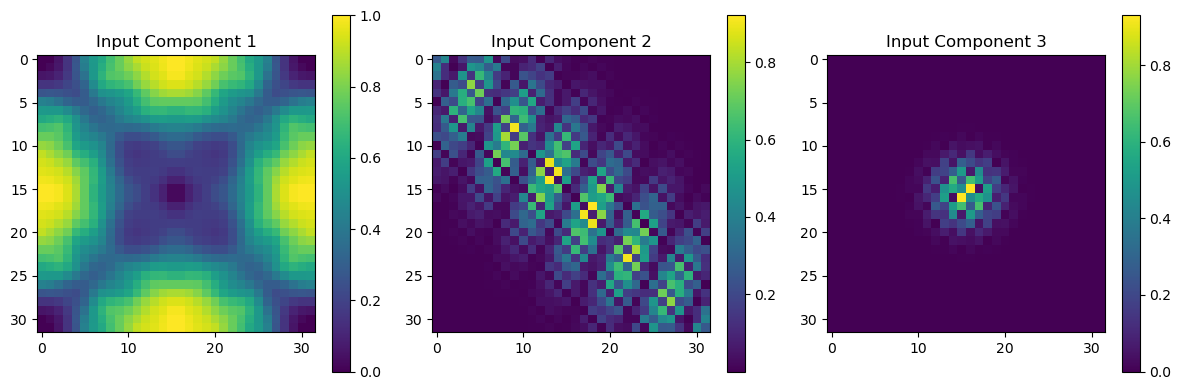

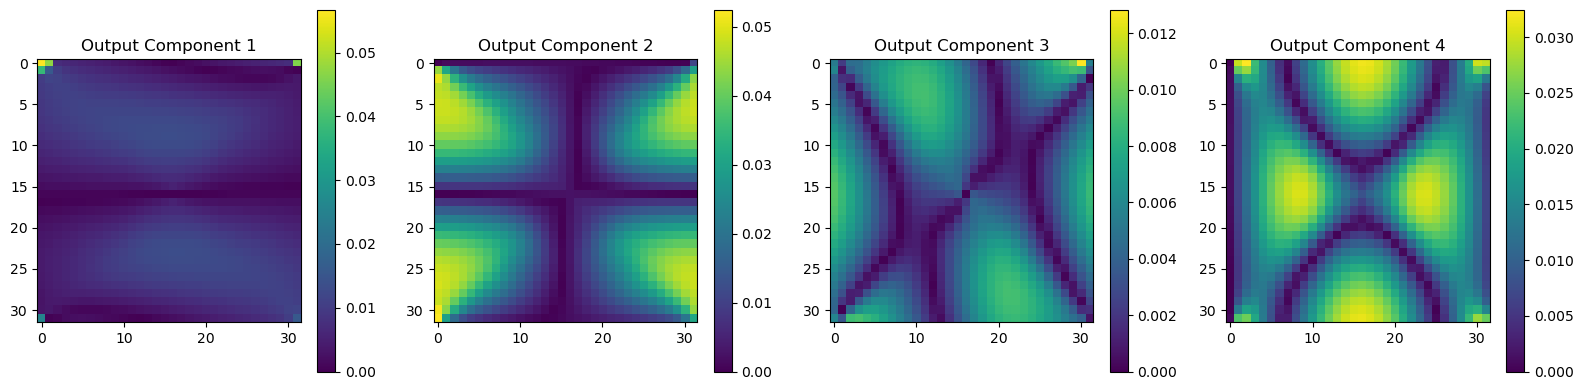


Visualizing sample 96 from loaded reduced dataset:


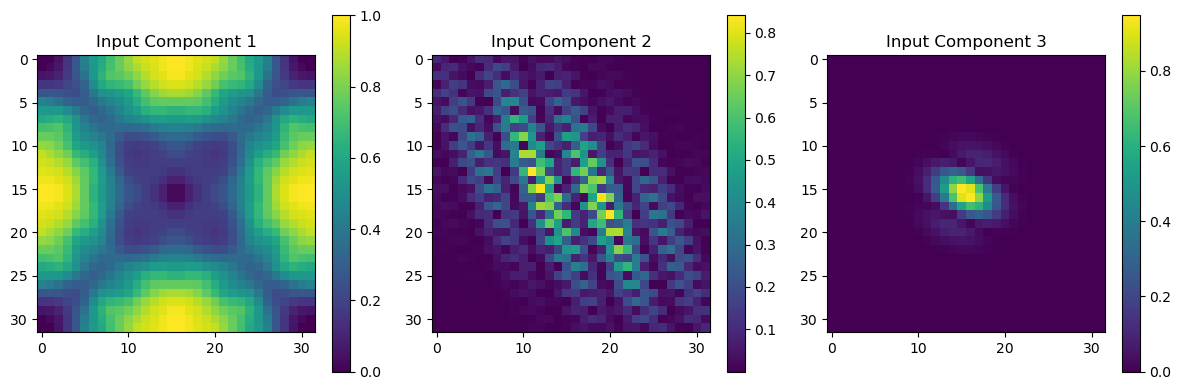

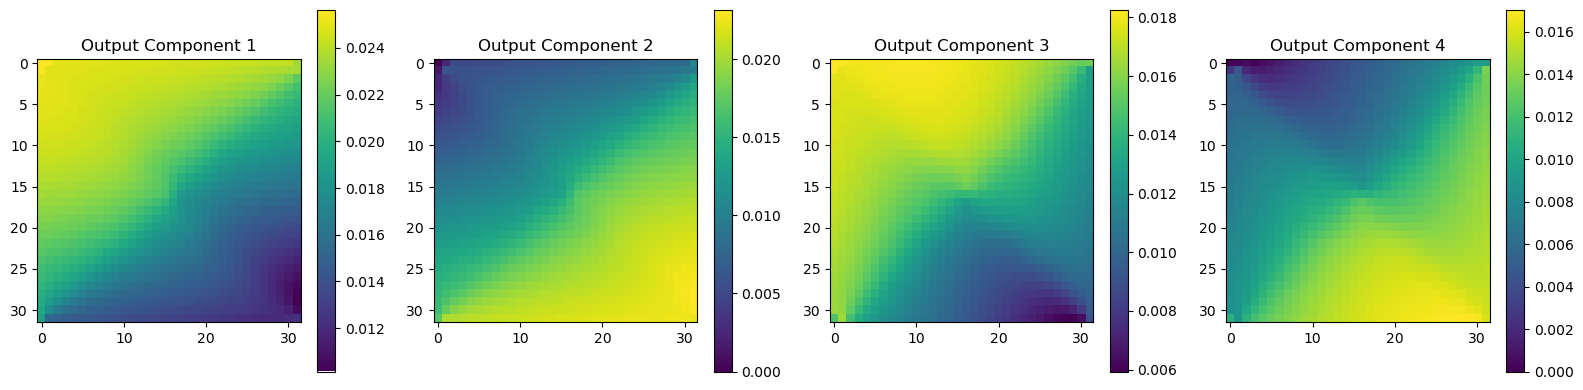


Visualizing sample 221 from loaded reduced dataset:


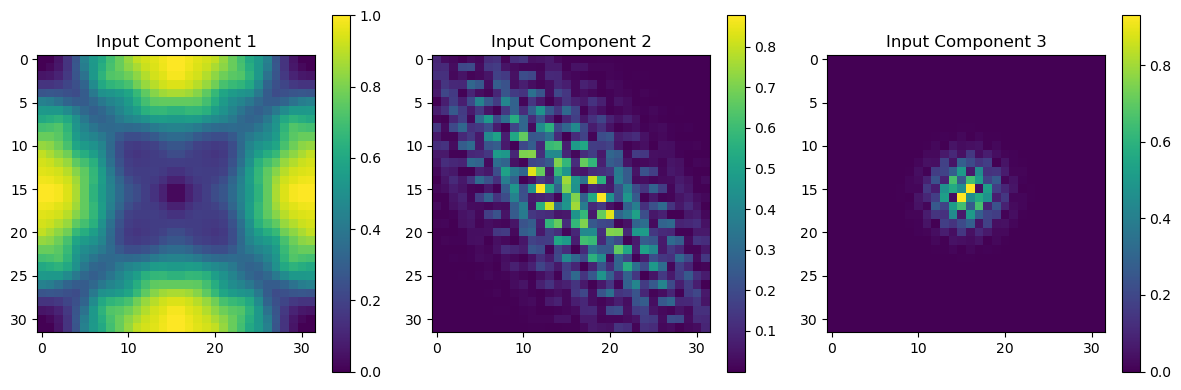

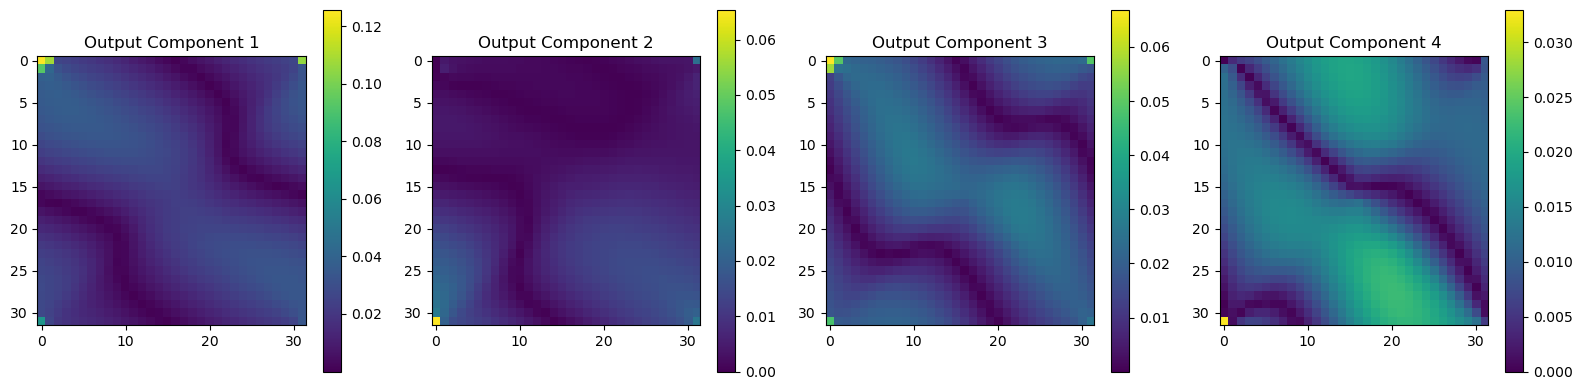


Visualizing sample 162 from loaded reduced dataset:


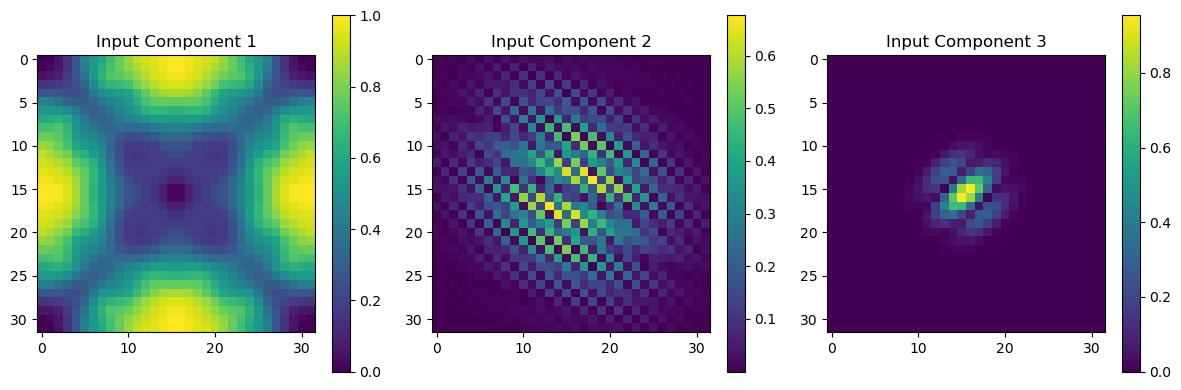

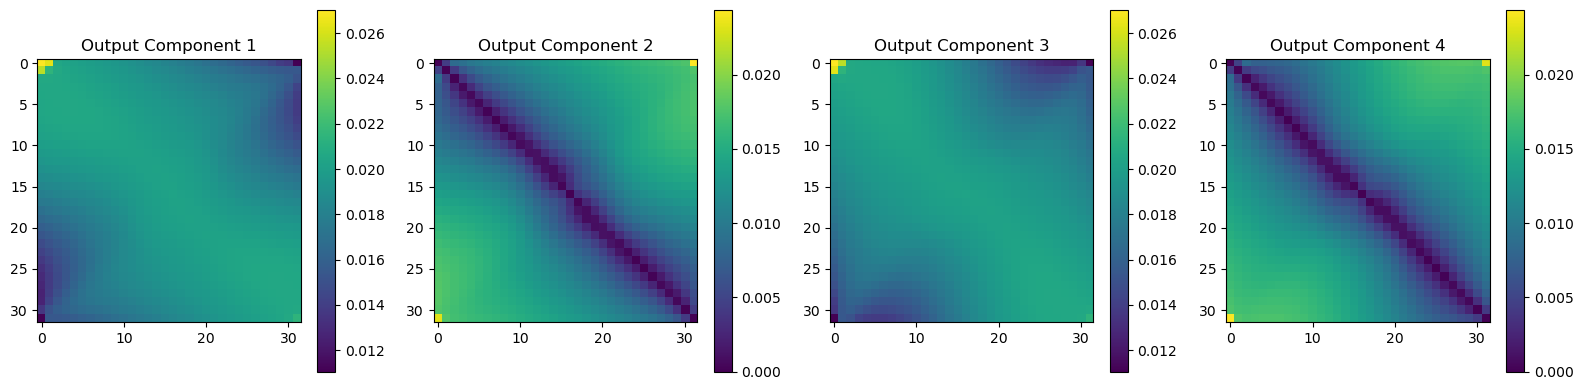


Visualizing sample 49 from loaded reduced dataset:


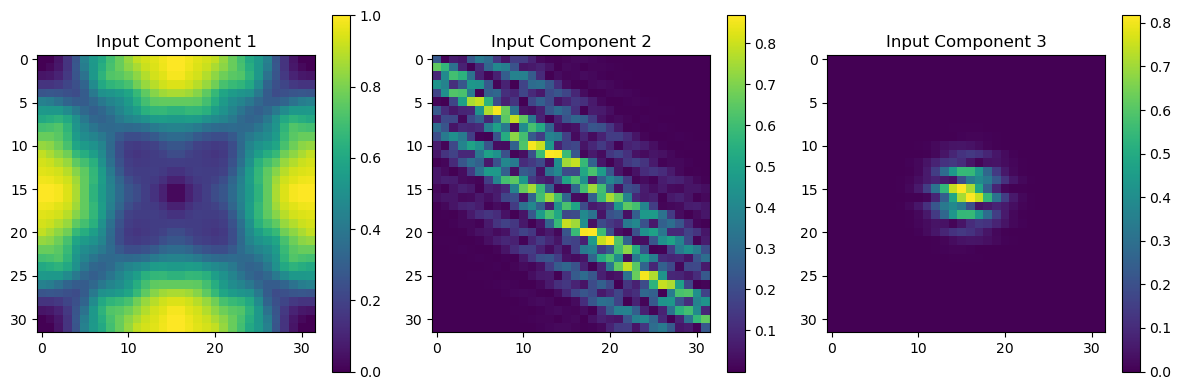

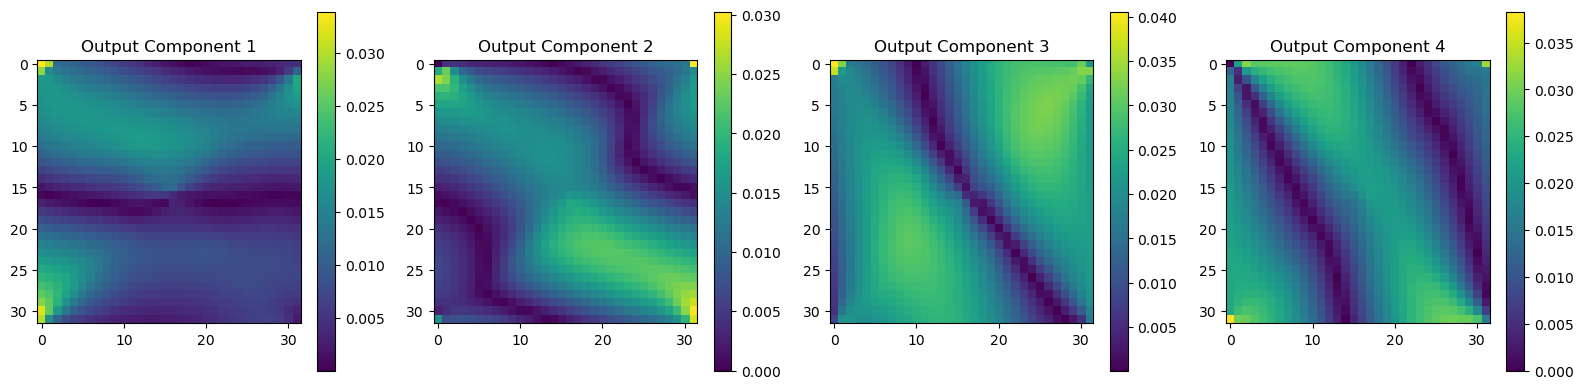


Visualizing sample 52 from loaded reduced dataset:


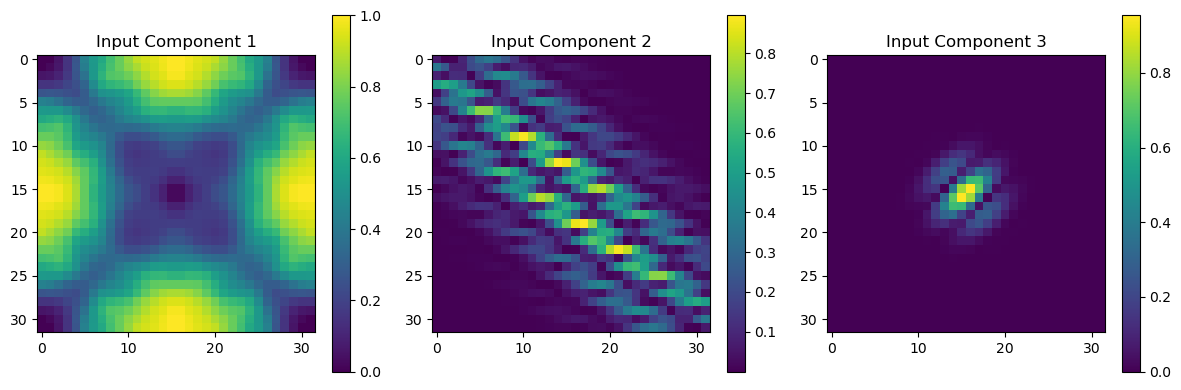

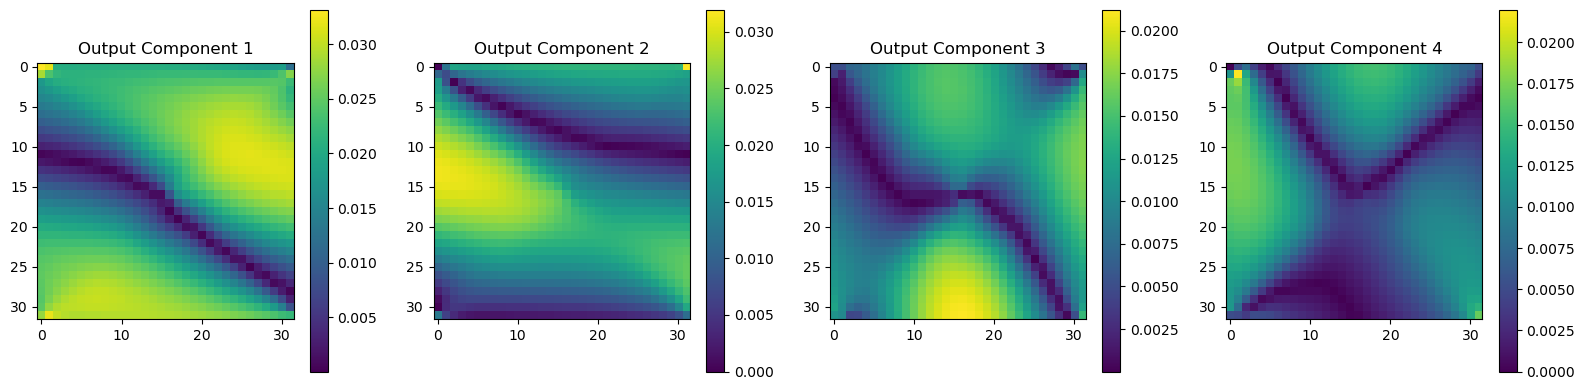


Visualizing sample 234 from loaded reduced dataset:


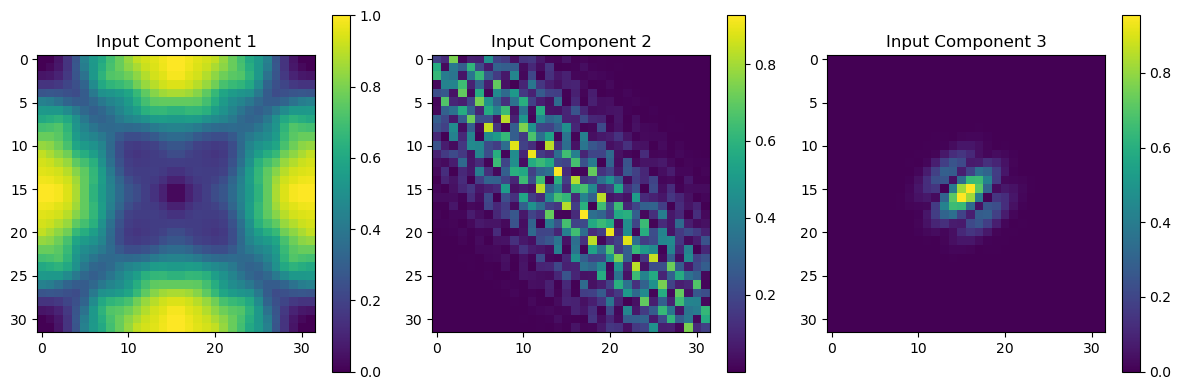

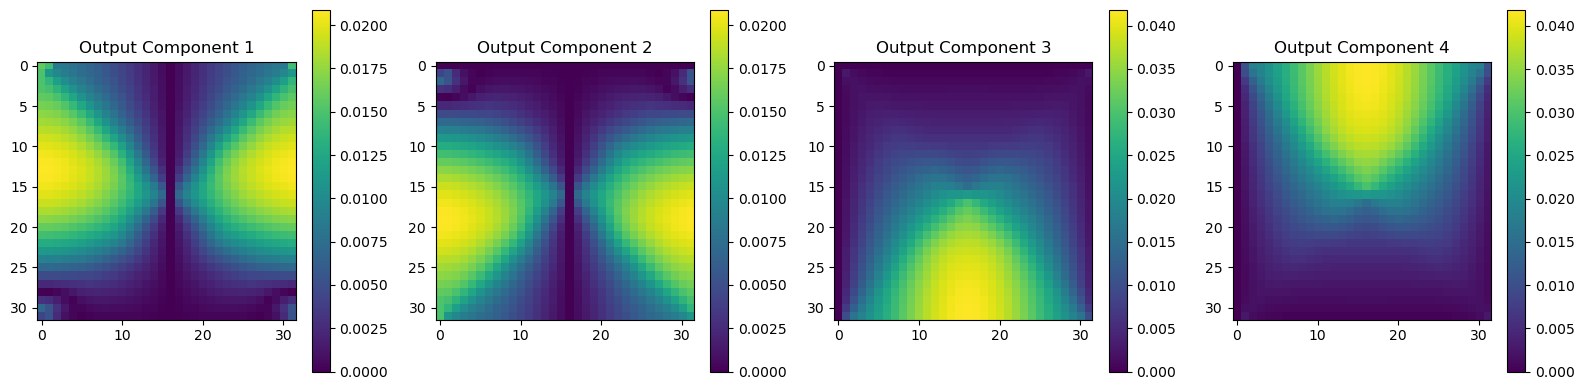


Visualizing sample 163 from loaded reduced dataset:


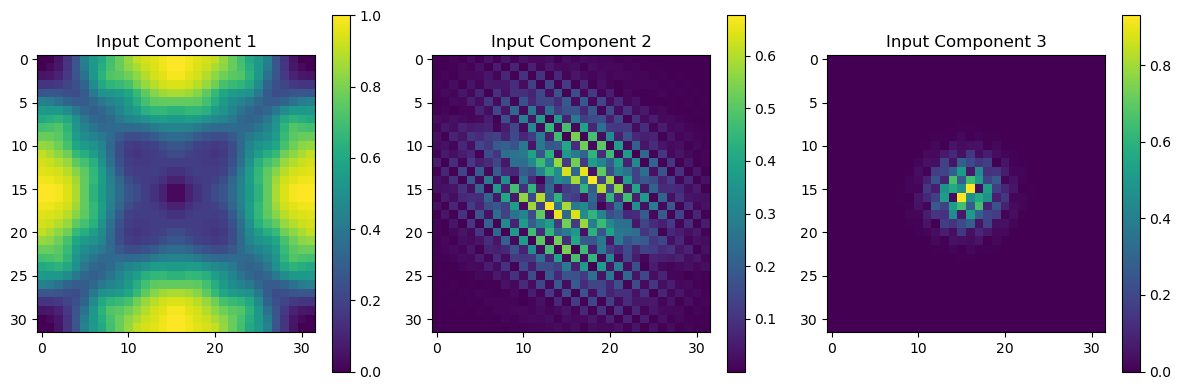

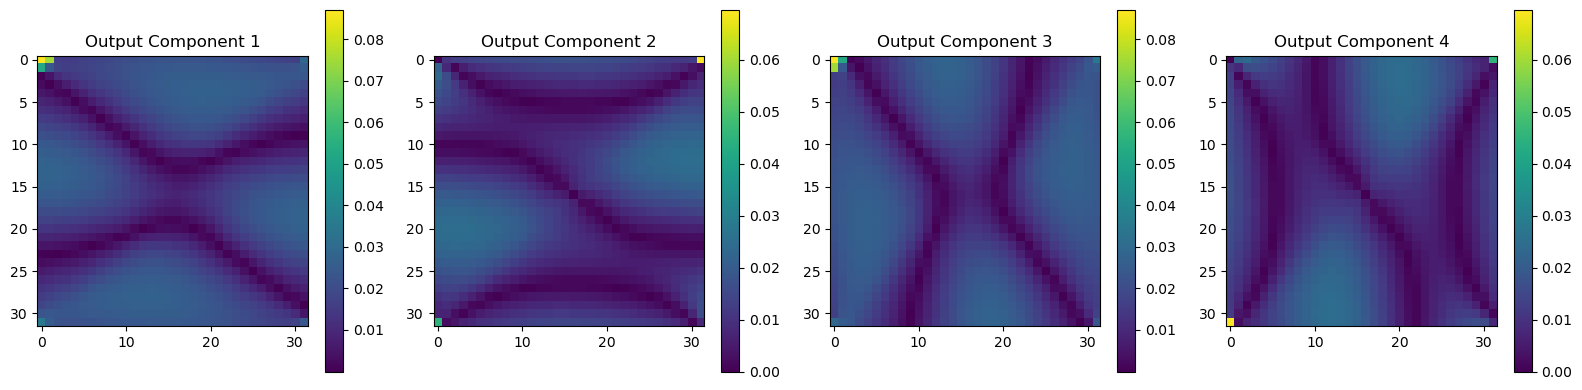


Visualizing sample 239 from loaded reduced dataset:


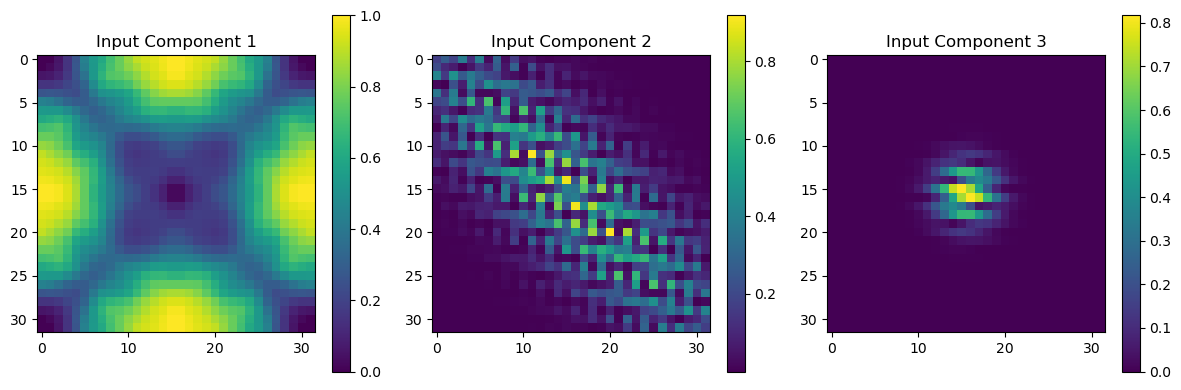

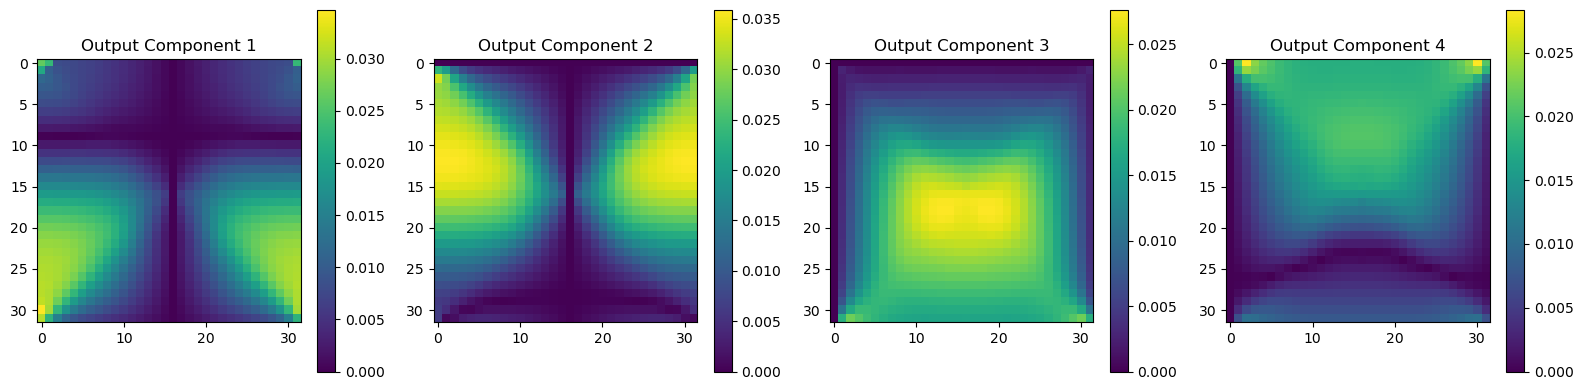


Visualizing sample 176 from loaded reduced dataset:


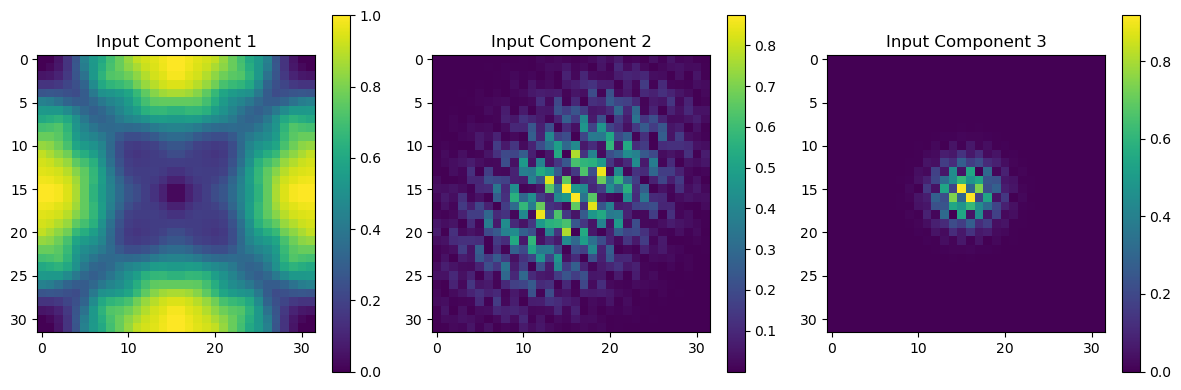

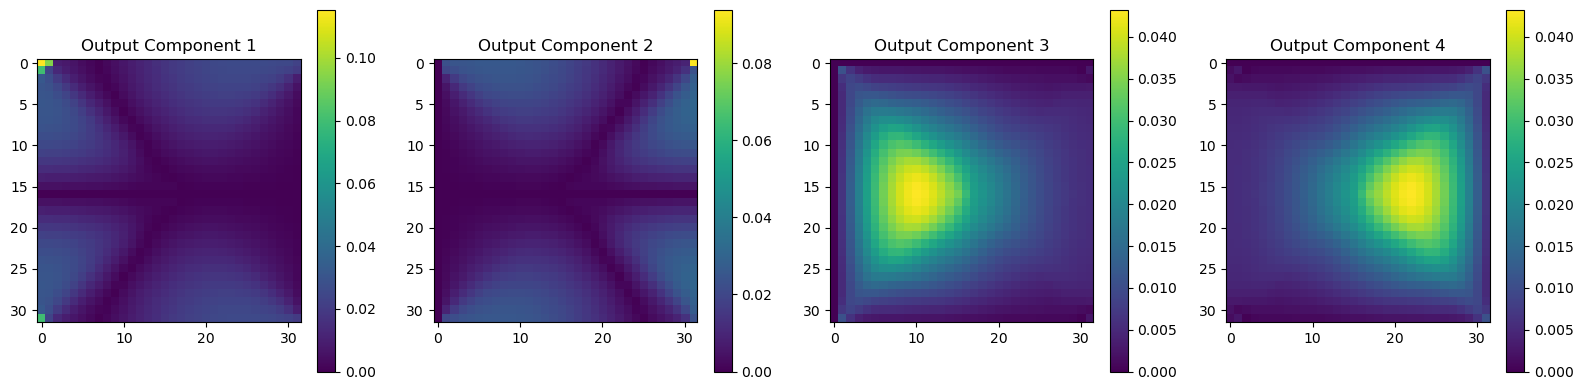


Visualizing sample 28 from loaded reduced dataset:


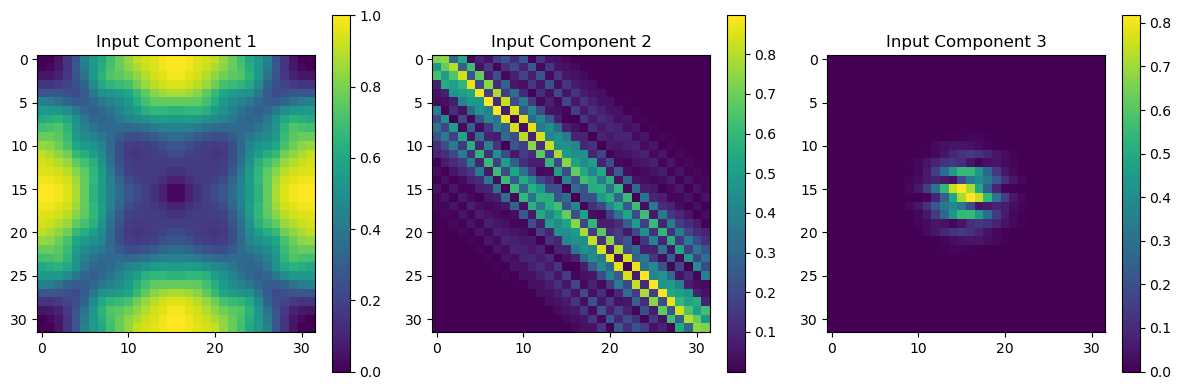

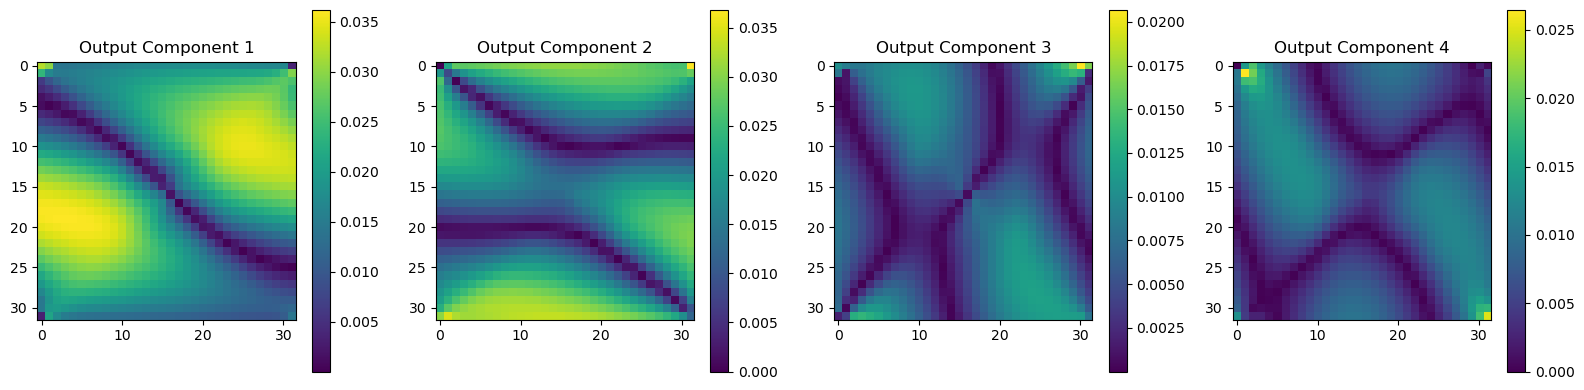


Visualizing sample 211 from loaded reduced dataset:


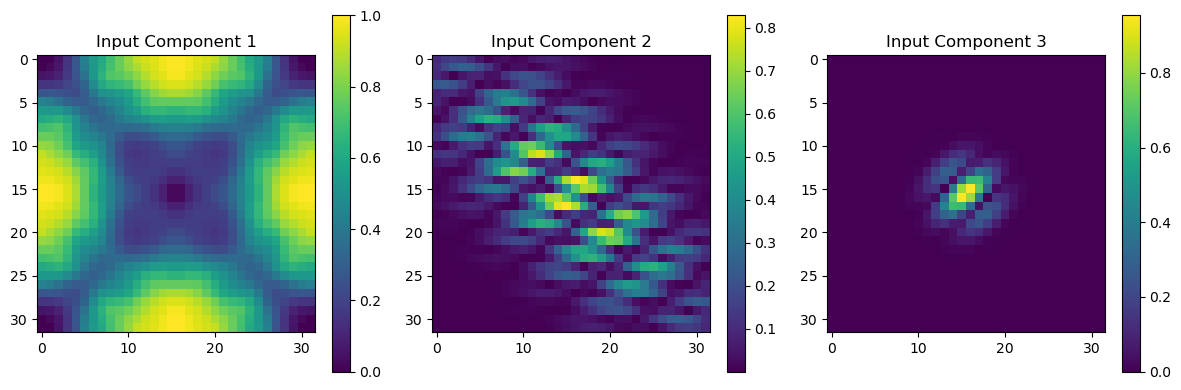

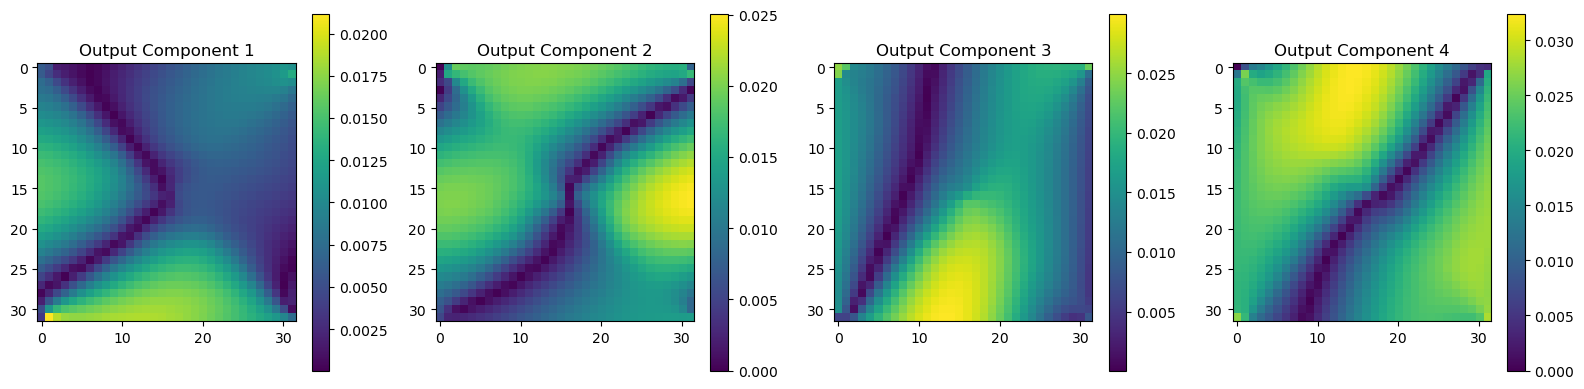


Visualizing random sample 211 from loaded reduced dataset:


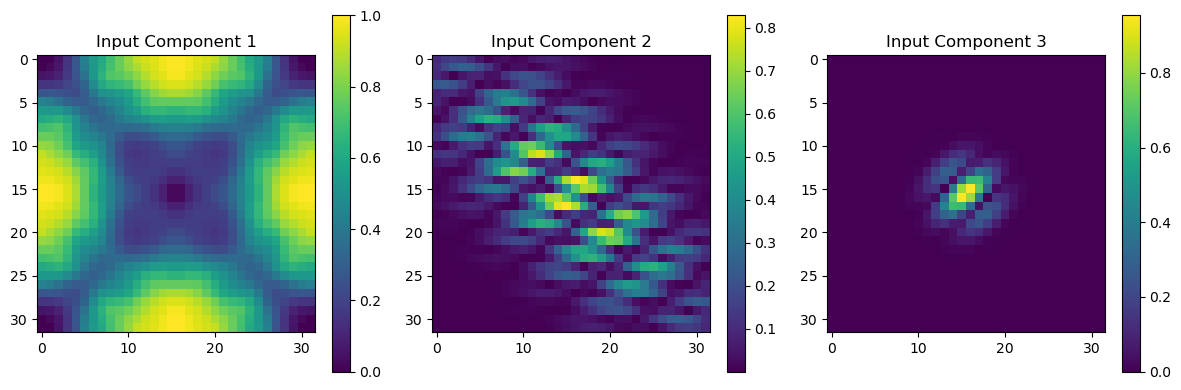

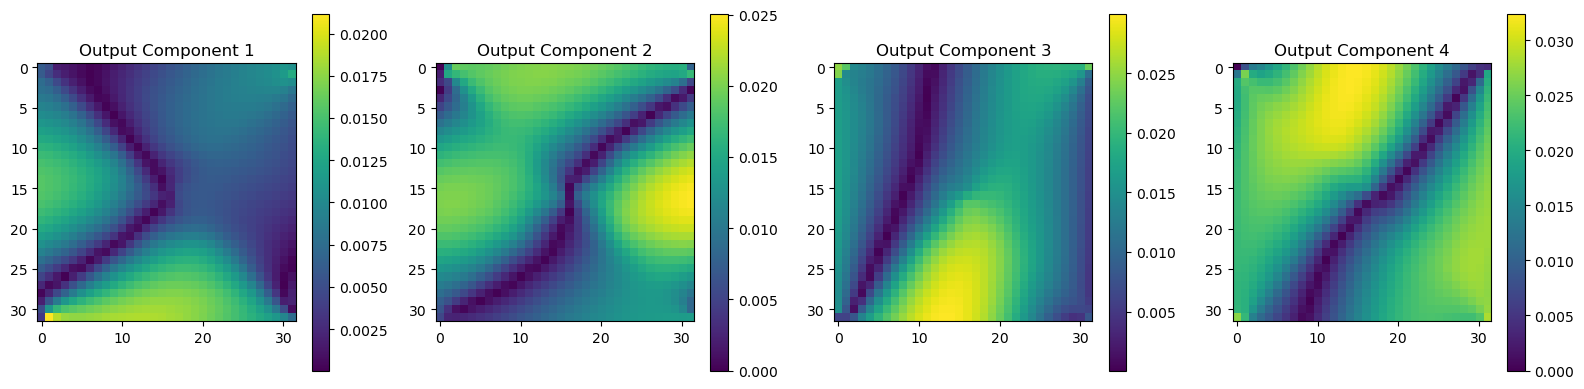

In [50]:
# Load the saved reduced dataset1
loaded_dataset = torch.load(os.path.join(reduced_datapath1, 'reduced_dataset1.pt'))

# Get a random sample index
#random_idx = np.random.randint(0, len(loaded_dataset))
# Randomly select 12 indices between 0 and 242
random_indices = np.random.choice(242, size=12, replace=False)
offset = 243
for random_idx in random_indices:
    # Get input and output tensors for each sample
    input_tensor, output_tensor = loaded_dataset[random_idx + offset]
    print(f"\nVisualizing sample {random_idx} from loaded reduced dataset:")
    visualize_sample(input_tensor, output_tensor)

print(f"\nVisualizing random sample {random_idx} from loaded reduced dataset:")
visualize_sample(input_tensor, output_tensor)


In [5]:
def load_and_reduce_dataset(data_path, waveform_subset_proportion=0.25, bands_subset_proportion=0.5, precision=torch.float32):
    """
    Load dataset from path and create reduced version by randomly sampling waveforms and bands.
    
    Args:
        data_path: Path to dataset folder
        waveform_subset_proportion: Proportion of waveforms to keep (default 0.25)
        bands_subset_proportion: Proportion of bands to keep (default 0.5)
        precision: Precision to use for tensors (default 'float32')
        
    Returns:
        dataset: Full TensorDataset
        reduced_dataset: Subset of full dataset
    """
    # Load dataset
    designs, design_params, waveforms, wavevectors, eigenvalue_data, eigenvector_data_x, eigenvector_data_y, bands_fft = load_dataset(data_path)

    # Print the shapes and types of dataset contents
    print(f'Dataset designs shape: {designs.shape}, dtype: {designs.dtype}')
    print(f'Dataset waveforms shape: {waveforms.shape}, dtype: {waveforms.dtype}')
    print(f'Dataset wavevectors shape: {wavevectors.shape}, dtype: {wavevectors.dtype}')
    print(f'Dataset eigenvalue_data shape: {eigenvalue_data.shape}, dtype: {eigenvalue_data.dtype}')
    print(f'Dataset eigenvector_data_x shape: {eigenvector_data_x.shape}, dtype: {eigenvector_data_x.dtype}')
    print(f'Dataset eigenvector_data_y shape: {eigenvector_data_y.shape}, dtype: {eigenvector_data_y.dtype}')
    print(f'Dataset bands_fft shape: {bands_fft.shape}, dtype: {bands_fft.dtype}')

    n_designs = np.shape(designs)[0]
    n_waveforms = np.shape(waveforms)[0]
    n_bands = np.shape(bands_fft)[0]

    dataset = make_TensorDataset(designs=designs,
                                waveforms=waveforms,
                                bands_fft=bands_fft,
                                eigenvector_data_x=eigenvector_data_x,
                                eigenvector_data_y=eigenvector_data_y,
                                precision=precision)
    
    # Print basic information about dataset
    print("\nDataset Information:")
    print(f"Total number of samples: {len(dataset)}")
    print(f"Input tensor size per sample: {dataset.tensors[0].size()[1:]}")
    print(f"Output tensor size per sample: {dataset.tensors[1].size()[1:]}")
    print(f'Input tensor dtype: {dataset.tensors[0].dtype}, Output tensor dtype: {dataset.tensors[1].dtype}')

    # Calculate subset sizes
    waveform_subset_size = int(n_waveforms * waveform_subset_proportion)
    bands_subset_size = int(n_bands * bands_subset_proportion)

    # Initialize vector of indices for the reduced dataset
    reduced_indices = np.zeros(len(dataset), dtype=int)
    print(f'reduced_indices shape: {reduced_indices.shape}')

    # For each design, select random subsets of waveforms and bands
    for d_idx in range(n_designs):
        # Get random waveform indices
        waveform_indices = np.random.choice(n_waveforms, size=waveform_subset_size, replace=False)
        
        for w_idx in waveform_indices:
            # Get random band indices
            band_indices = np.random.choice(n_bands, size=bands_subset_size, replace=False)
            
            # Calculate indices for this design's samples
            for b_idx in band_indices:
                sample_idx = d_idx * (n_waveforms * n_bands) + w_idx * n_bands + b_idx
                reduced_indices[sample_idx] = 1

    # Convert to boolean mask
    reduced_indices = reduced_indices.astype(bool)
    # Print the total number of selected samples in reduced dataset
    print(f'Number of samples in reduced dataset: {np.sum(reduced_indices)} ({np.sum(reduced_indices)/len(dataset):.2%} of original)')

    # Use boolean mask to select samples from dataset
    reduced_dataset = torch.utils.data.Subset(dataset, np.where(reduced_indices)[0])

    # Print info about reduced dataset
    print("\nReduced Dataset Information:")
    print(f"Total number of samples: {len(reduced_dataset)}")
    print(f"Input tensor size per sample: {reduced_dataset.dataset.tensors[0].size()[1:]}")
    print(f"Output tensor size per sample: {reduced_dataset.dataset.tensors[1].size()[1:]}")
    
    return reduced_dataset

def save_reduced_dataset(reduced_dataset, datafolder_path, suffix=''):
    """
    Save a reduced dataset to disk and print its details.
    
    Args:
        reduced_dataset: A torch Subset dataset containing the reduced data
        datafolder_path: Path where the dataset should be saved
        suffix: String to append to filename (default '')
    """
    os.makedirs(datafolder_path, exist_ok=True)

    # Extract just the input and output tensors for the subset indices
    input_tensors = reduced_dataset.dataset.tensors[0][reduced_dataset.indices]
    output_tensors = reduced_dataset.dataset.tensors[1][reduced_dataset.indices]
    subset_data = TensorDataset(input_tensors, output_tensors)

    # Print basic information about the subset data
    print("\nSubset Data Details:")
    print(f"Number of samples: {len(subset_data)}")
    print(f"Input tensor shape: {subset_data[0][0].shape}, dtype: {subset_data[0][0].dtype}")
    print(f"Output tensor shape: {subset_data[0][1].shape}, dtype: {subset_data[0][1].dtype}")

    filename = f'reduced_dataset{suffix}.pt'
    save_path = os.path.join(datafolder_path, filename)
    torch.save(subset_data, save_path)
    print(f"Saved reduced dataset to {save_path}")

def visualize_sample(input_tensor, output_tensor):
    """
    Visualize input and output tensors from a single sample.
    
    Args:
        input_tensor: Tensor of shape (3, H, W) containing input components
        output_tensor: Tensor of shape (4, H, W) containing output components
    """
    # Create figure for input components
    fig1 = plt.figure(figsize=(12, 4))

    # Plot input tensor components (1x3 subplot)
    for i in range(3):
        plt.subplot(1, 3, i+1)
        im = plt.imshow(input_tensor[i].abs().numpy())
        plt.colorbar(im)
        plt.title(f'Input Component {i+1}')

    plt.tight_layout()
    plt.show()

    # Create figure for output components 
    fig2 = plt.figure(figsize=(16, 4))

    # Plot output tensor components (1x4 subplot)
    for i in range(4):
        plt.subplot(1, 4, i+1)
        im = plt.imshow(output_tensor[i].abs().numpy())
        plt.colorbar(im)
        plt.title(f'Output Component {i+1}')

    plt.tight_layout()
    plt.show()

def visualize_random_samples(dataset_path, offset=0, n_samples=12, design_window=None):
    """
    Load a dataset and visualize random samples from it.
    
    Args:
        dataset_path: Path to the dataset file
        offset: Offset to add to random indices (default: 0)
        n_samples: Number of random samples to visualize (default: 12)
        design_window: If not None, only sample from offset to offset+design_window
    """
    # Load the dataset
    pt_files = [f for f in os.listdir(dataset_path) if f.endswith('.pt')]
    if not pt_files:
        raise FileNotFoundError(f"No .pt files found in {dataset_path}")
    loaded_dataset = torch.load(os.path.join(dataset_path, pt_files[0]))
    
    # Randomly select indices based on design_window
    if design_window is not None:
        max_idx = min(offset + design_window, len(loaded_dataset))
        print(f"Sampling {min(n_samples, max_idx-offset)} indices from range [{offset}, {max_idx})")
        random_indices = np.random.choice(range(offset, max_idx), size=min(n_samples, max_idx-offset), replace=False)
    else:
        print(f"Sampling {n_samples} indices from range [0, {len(loaded_dataset)-offset})")
        random_indices = np.random.choice(len(loaded_dataset)-offset, size=n_samples, replace=False)
    
    for random_idx in random_indices:
        # Get input and output tensors for each sample
        input_tensor, output_tensor = loaded_dataset[random_idx]
        print(f"\nVisualizing sample {random_idx} from loaded reduced dataset:")
        visualize_sample(input_tensor, output_tensor)

    print(f"\nVisualizing random sample {random_idx} from loaded reduced dataset:")
    visualize_sample(input_tensor, output_tensor)

***Process Dataset1***

In [12]:
datafolder_name1 = ["data", "set 1"]
data_path1 = os.path.join(*datafolder_name1)
waveform_subset_proportion1 = 0.25
bands_subset_proportion1 = 0.5
precision1 = torch.float32
reduced_dataset1 = load_and_reduce_dataset(data_path1, 
                                           waveform_subset_proportion=waveform_subset_proportion1, 
                                           bands_subset_proportion=bands_subset_proportion1, 
                                           precision=precision1)

reduced_datafolder1_name = ["data", "reduced", "set 1"]
reduced_datapath1 = os.path.join(*reduced_datafolder1_name)
os.makedirs(reduced_datapath1, exist_ok=True)
save_reduced_dataset(reduced_dataset1, reduced_datapath1, suffix='1_ws4_bs2_f32')

Dataset loaded from data\set 1
Dataset designs shape: (600, 32, 32), dtype: float64
Dataset waveforms shape: (325, 32, 32), dtype: float64
Dataset wavevectors shape: (600, 325, 2), dtype: float16
Dataset eigenvalue_data shape: (600, 325, 6), dtype: float16
Dataset eigenvector_data_x shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset eigenvector_data_y shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset bands_fft shape: (6, 32, 32), dtype: float64
Dataset creation took 71.24 seconds
Input tensor shape: torch.Size([1170000, 3, 32, 32])
Output tensor shape: torch.Size([1170000, 4, 32, 32])
Number of samples in dataset: 1170000

Dataset Information:
Total number of samples: 1170000
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])
Input tensor dtype: torch.float32, Output tensor dtype: torch.float32
reduced_indices shape: (1170000,)
Number of samples in reduced dataset: 145800 (12.46% of original)

Reduced Dataset Informatio

In [18]:
#visualize_random_samples(dataset_path=reduced_datapath1, n_samples=6, design_window=243)

# Delete dataset1 related variables to free up memory
del reduced_dataset1


***Process Dataset2***

In [13]:
datafolder_name2 = ["data", "set 2"]
data_path2 = os.path.join(*datafolder_name2)
waveform_subset_proportion2 = 0.25
bands_subset_proportion2 = 0.5
precision2 = torch.float32
reduced_dataset2 = load_and_reduce_dataset(data_path2,
                                           waveform_subset_proportion=waveform_subset_proportion2,
                                           bands_subset_proportion=bands_subset_proportion2,
                                           precision=precision2)
reduced_datafolder2_name = ["data", "reduced", "set 2"]
reduced_datapath2 = os.path.join(*reduced_datafolder2_name)
os.makedirs(reduced_datapath2, exist_ok=True)
save_reduced_dataset(reduced_dataset2, reduced_datapath2, suffix='2_ws4_bs2_f32')

Dataset loaded from data\set 2
Dataset designs shape: (600, 32, 32), dtype: float64
Dataset waveforms shape: (325, 32, 32), dtype: float64
Dataset wavevectors shape: (600, 325, 2), dtype: float16
Dataset eigenvalue_data shape: (600, 325, 6), dtype: float16
Dataset eigenvector_data_x shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset eigenvector_data_y shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset bands_fft shape: (6, 32, 32), dtype: float64
Dataset creation took 57.17 seconds
Input tensor shape: torch.Size([1170000, 3, 32, 32])
Output tensor shape: torch.Size([1170000, 4, 32, 32])
Number of samples in dataset: 1170000

Dataset Information:
Total number of samples: 1170000
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])
Input tensor dtype: torch.float32, Output tensor dtype: torch.float32
reduced_indices shape: (1170000,)
Number of samples in reduced dataset: 145800 (12.46% of original)

Reduced Dataset Informatio

In [19]:
# visualize_random_samples(dataset_path=reduced_datapath2, n_samples=6, design_window=243)

# Delete dataset2 related variables to free up memory
del reduced_dataset2

***Process Dataset3***

Dataset loaded from data\set 3
Dataset designs shape: (600, 32, 32), dtype: float64
Dataset waveforms shape: (325, 32, 32), dtype: float64
Dataset wavevectors shape: (600, 325, 2), dtype: float16
Dataset eigenvalue_data shape: (600, 325, 6), dtype: float16
Dataset eigenvector_data_x shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset eigenvector_data_y shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset bands_fft shape: (6, 32, 32), dtype: float64
Dataset creation took 114.60 seconds
Input tensor shape: torch.Size([1170000, 3, 32, 32])
Output tensor shape: torch.Size([1170000, 4, 32, 32])
Number of samples in dataset: 1170000

Dataset Information:
Total number of samples: 1170000
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])
Input tensor dtype: torch.float32, Output tensor dtype: torch.float32
reduced_indices shape: (1170000,)
Number of samples in reduced dataset: 145800 (12.46% of original)

Reduced Dataset Informati

C:\Users\hz283\AppData\Local\Temp\ipykernel_12660\1429734626.py:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_dataset = torch.load(os.path.join(dataset_path, pt_

Sampling 6 indices from range [0, 243)

Visualizing sample 20 from loaded reduced dataset:


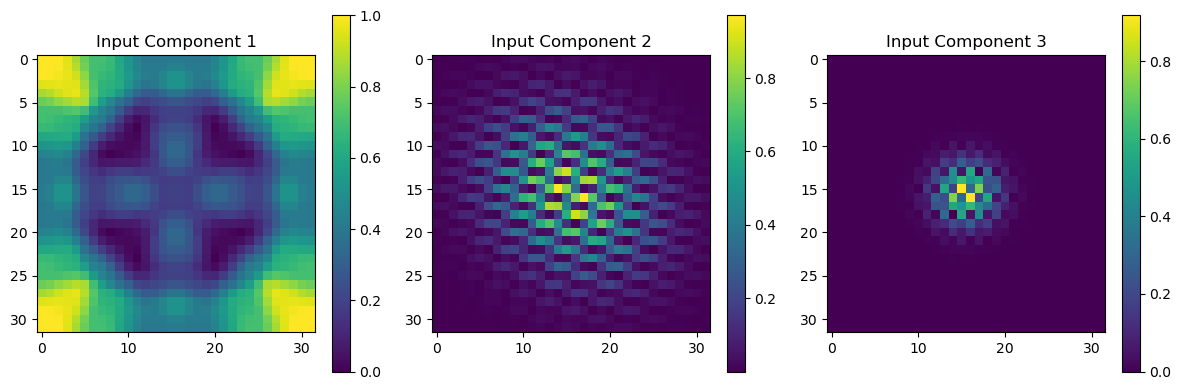

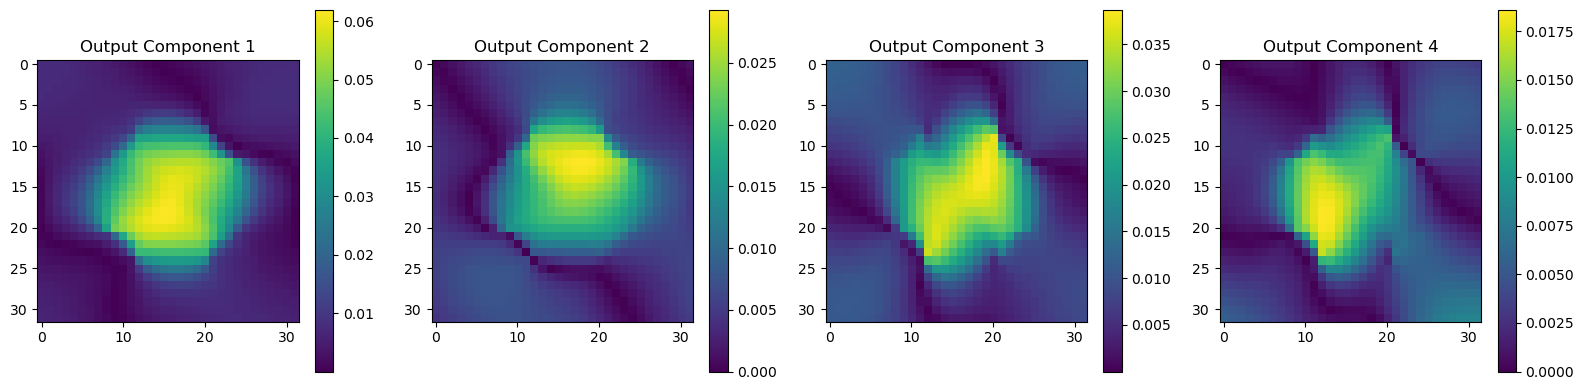


Visualizing sample 60 from loaded reduced dataset:


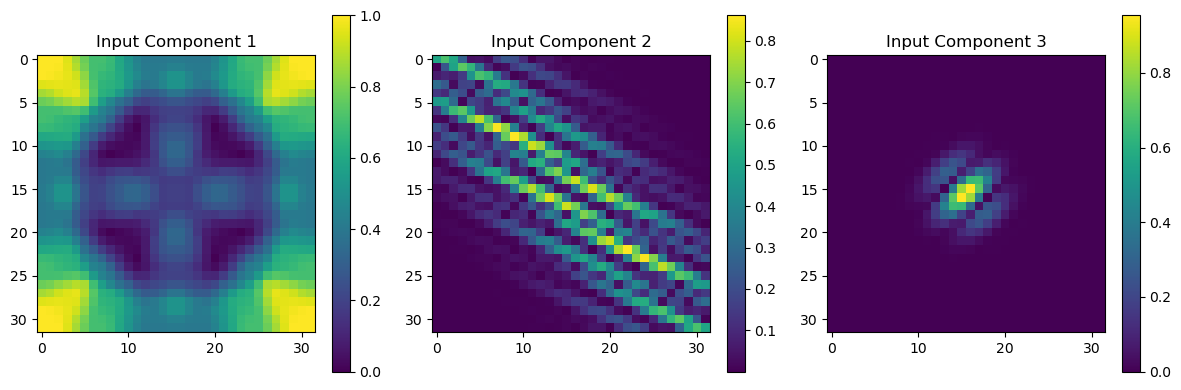

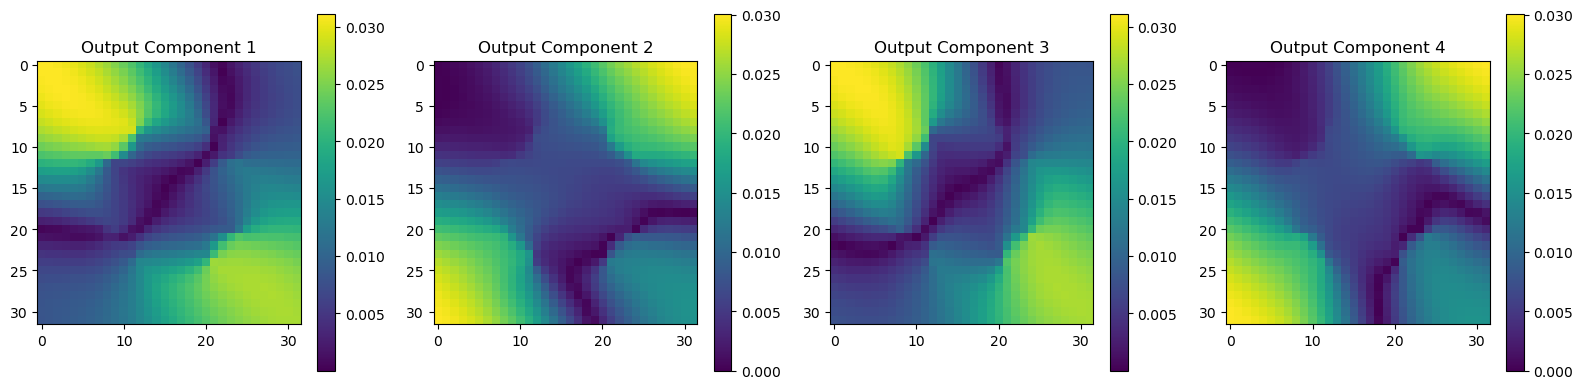


Visualizing sample 131 from loaded reduced dataset:


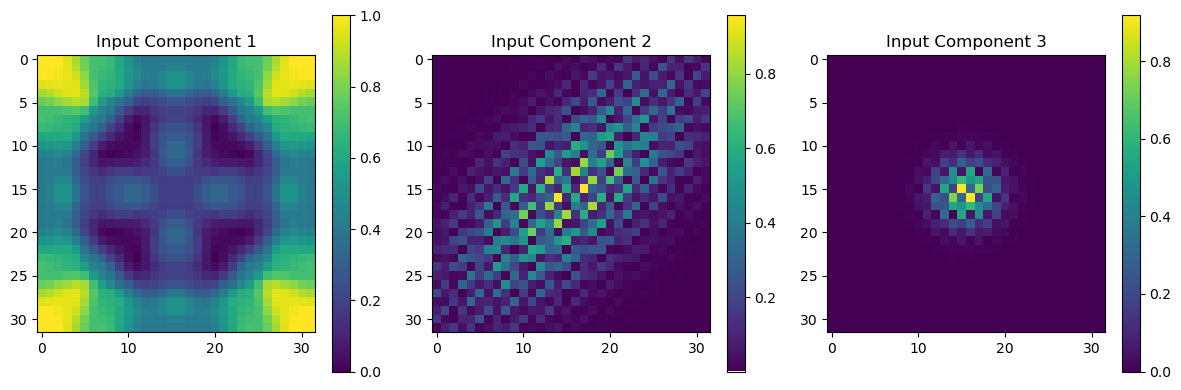

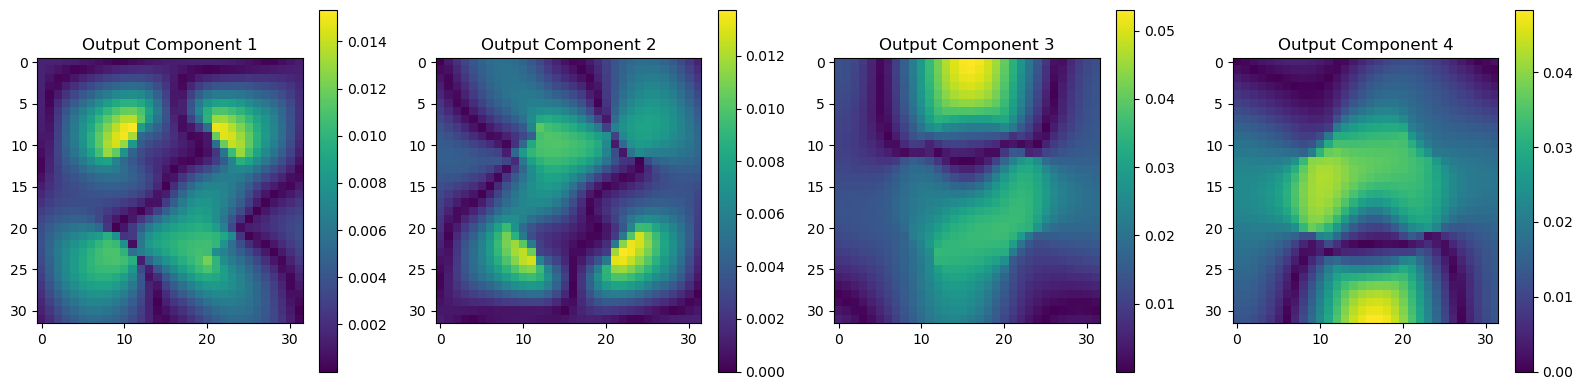


Visualizing sample 29 from loaded reduced dataset:


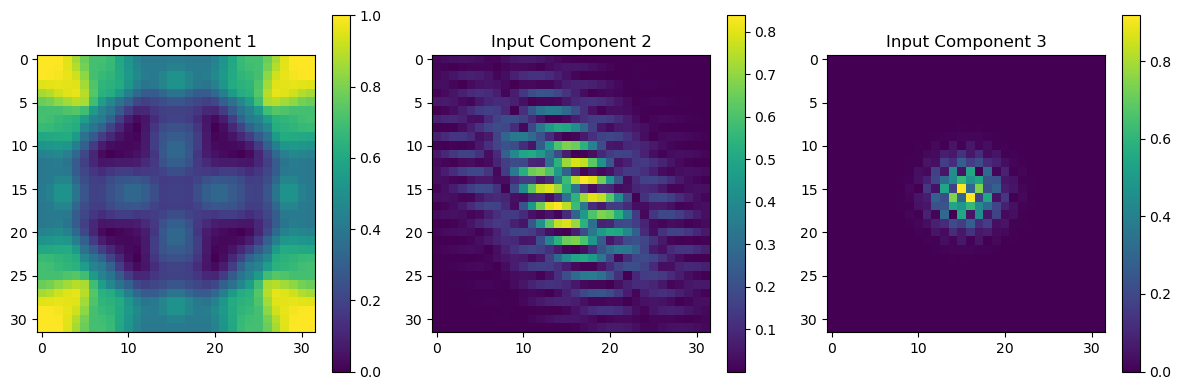

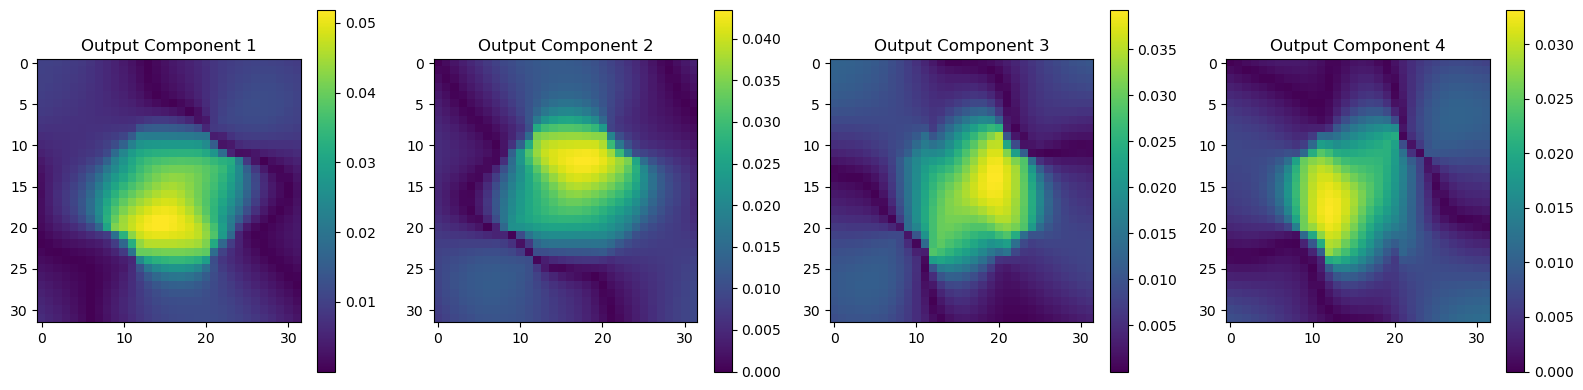


Visualizing sample 151 from loaded reduced dataset:


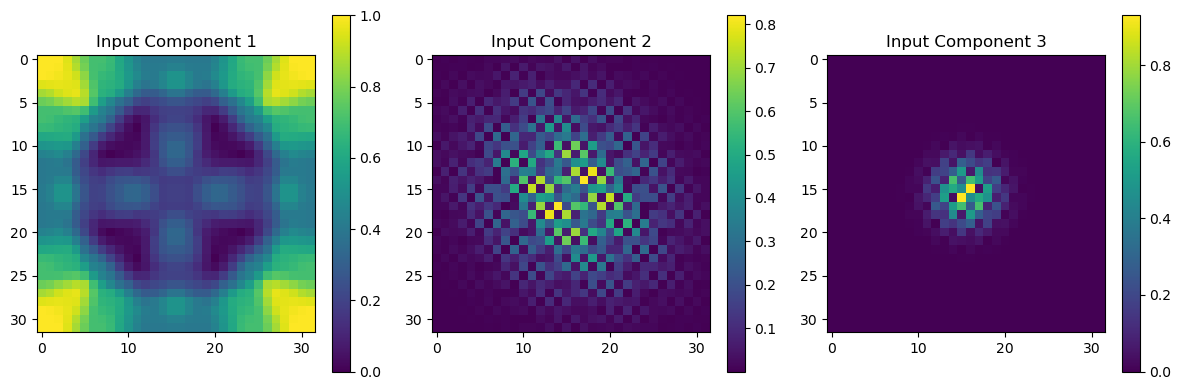

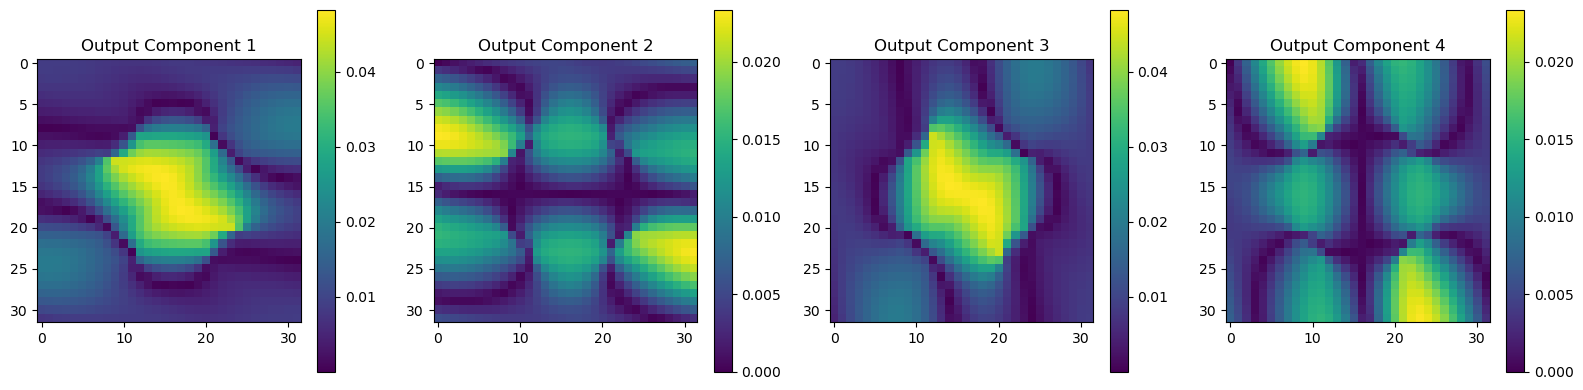


Visualizing sample 57 from loaded reduced dataset:


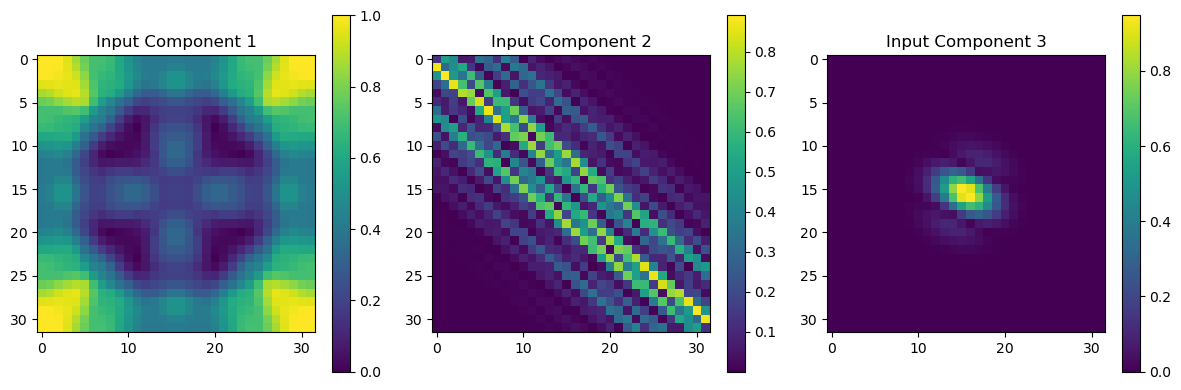

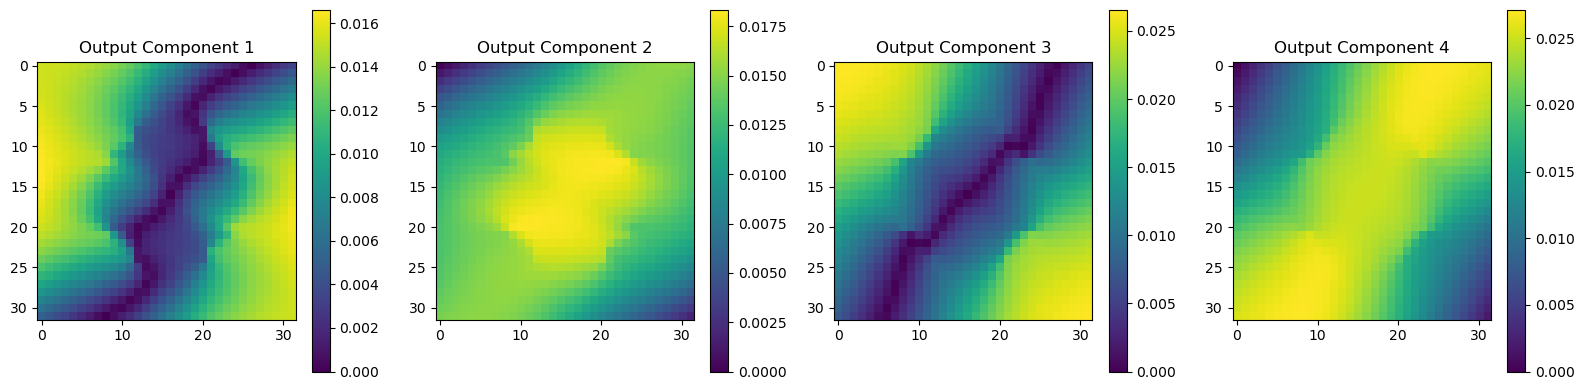


Visualizing random sample 57 from loaded reduced dataset:


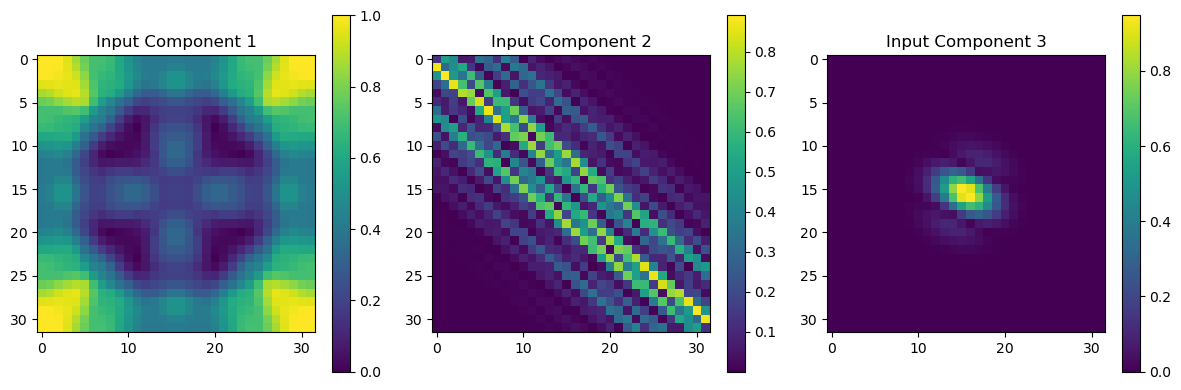

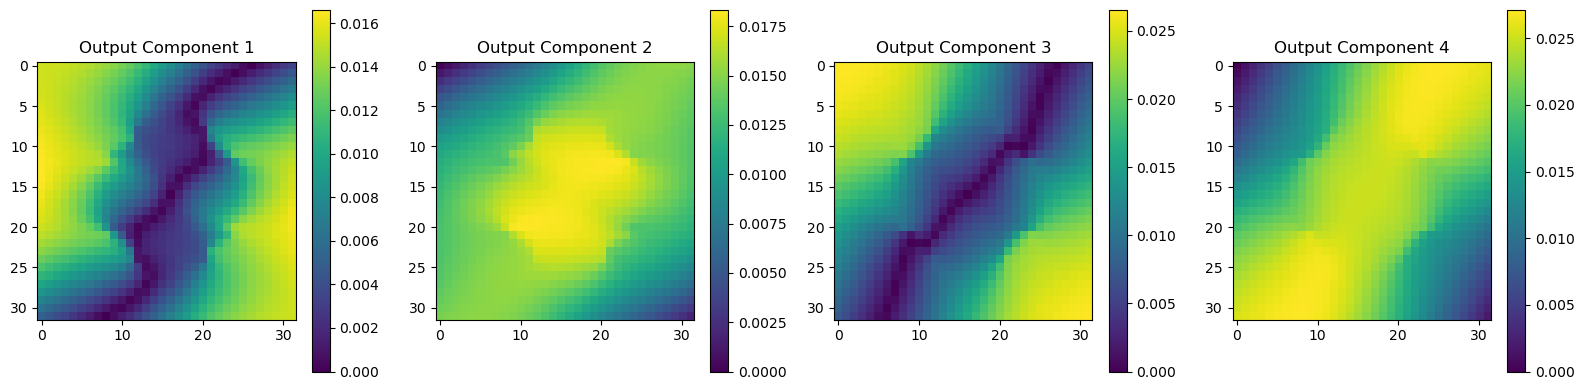

In [14]:
datafolder_name3 = ["data", "set 3"]
data_path3 = os.path.join(*datafolder_name3)
waveform_subset_proportion3 = 0.25
bands_subset_proportion3 = 0.5
precision3 = torch.float32
reduced_dataset3 = load_and_reduce_dataset(data_path3,
                                           waveform_subset_proportion=waveform_subset_proportion3,
                                           bands_subset_proportion=bands_subset_proportion3,
                                           precision=precision3)

reduced_datafolder3_name = ["data", "reduced", "set 3"]
reduced_datapath3 = os.path.join(*reduced_datafolder3_name)
os.makedirs(reduced_datapath3, exist_ok=True)
save_reduced_dataset(reduced_dataset3, reduced_datapath3, suffix='3_ws4_bs2_f32')

In [20]:
#visualize_random_samples(dataset_path=reduced_datapath3, n_samples=6, design_window=243)

# Delete dataset3 related variables to free up memory
del reduced_dataset3

***Process Dataset4***

Dataset loaded from data\set 4
Dataset designs shape: (600, 32, 32), dtype: float64
Dataset waveforms shape: (325, 32, 32), dtype: float64
Dataset wavevectors shape: (600, 325, 2), dtype: float16
Dataset eigenvalue_data shape: (600, 325, 6), dtype: float16
Dataset eigenvector_data_x shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset eigenvector_data_y shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset bands_fft shape: (6, 32, 32), dtype: float64
Dataset creation took 73.87 seconds
Input tensor shape: torch.Size([1170000, 3, 32, 32])
Output tensor shape: torch.Size([1170000, 4, 32, 32])
Number of samples in dataset: 1170000

Dataset Information:
Total number of samples: 1170000
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])
Input tensor dtype: torch.float32, Output tensor dtype: torch.float32
reduced_indices shape: (1170000,)
Number of samples in reduced dataset: 145800 (12.46% of original)

Reduced Dataset Informatio

C:\Users\hz283\AppData\Local\Temp\ipykernel_12660\1429734626.py:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_dataset = torch.load(os.path.join(dataset_path, pt_

Sampling 6 indices from range [0, 243)

Visualizing sample 98 from loaded reduced dataset:


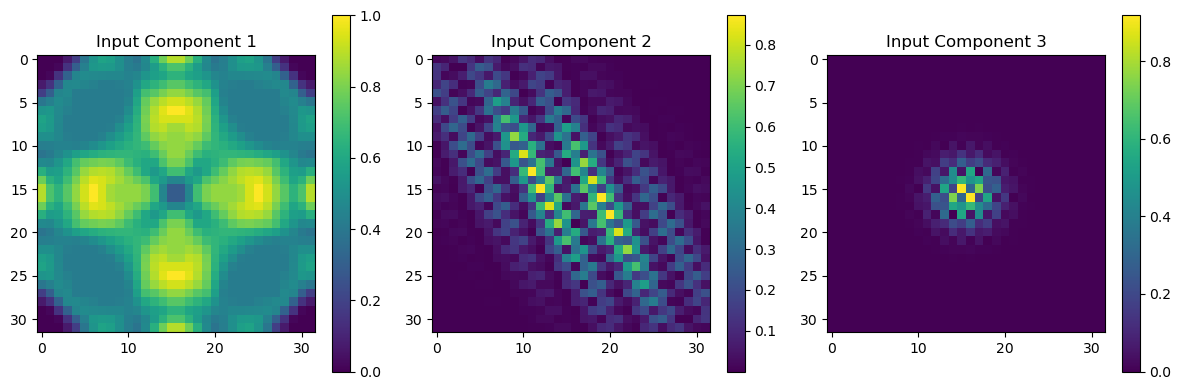

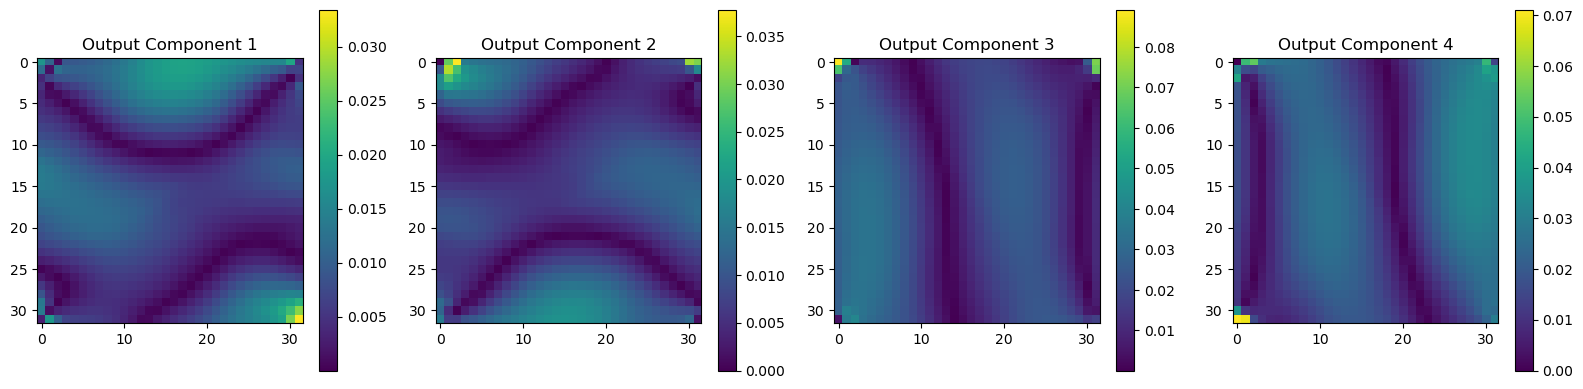


Visualizing sample 49 from loaded reduced dataset:


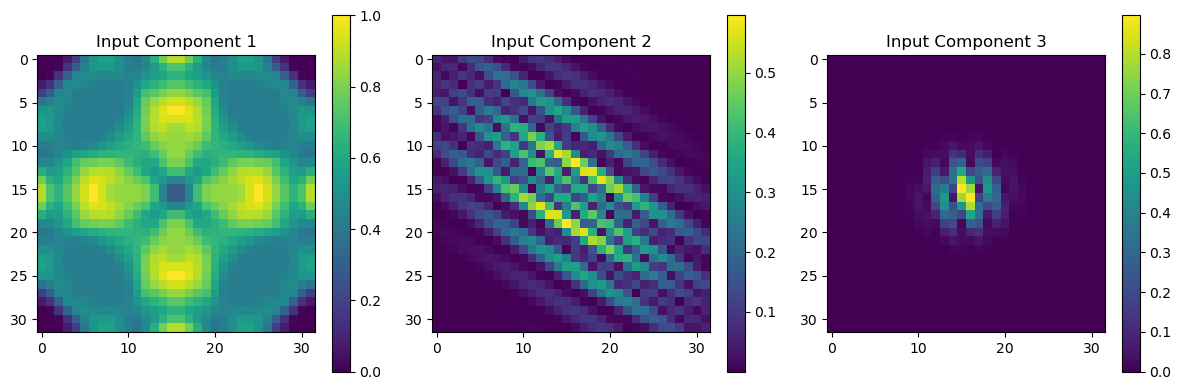

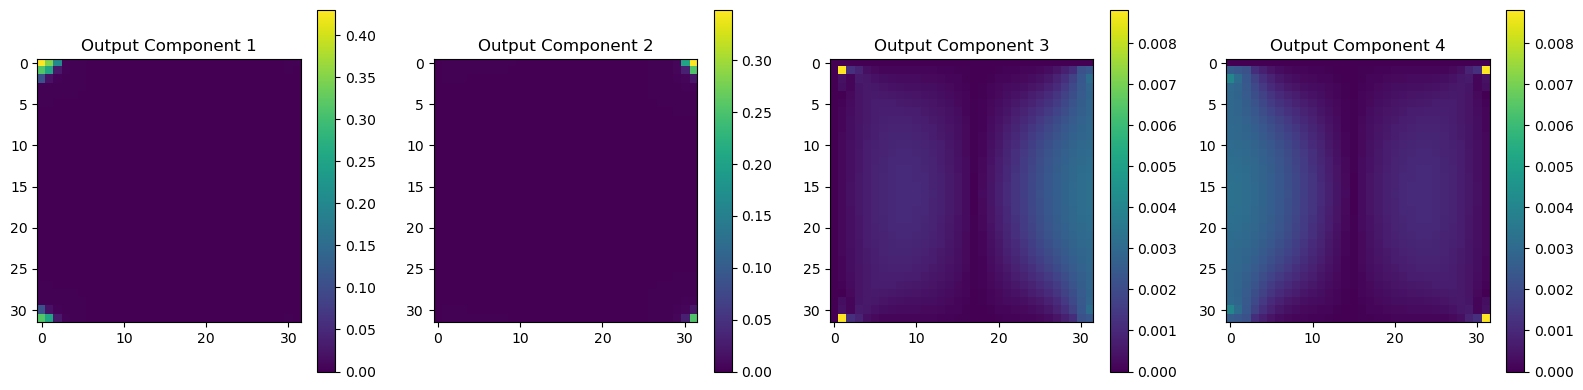


Visualizing sample 155 from loaded reduced dataset:


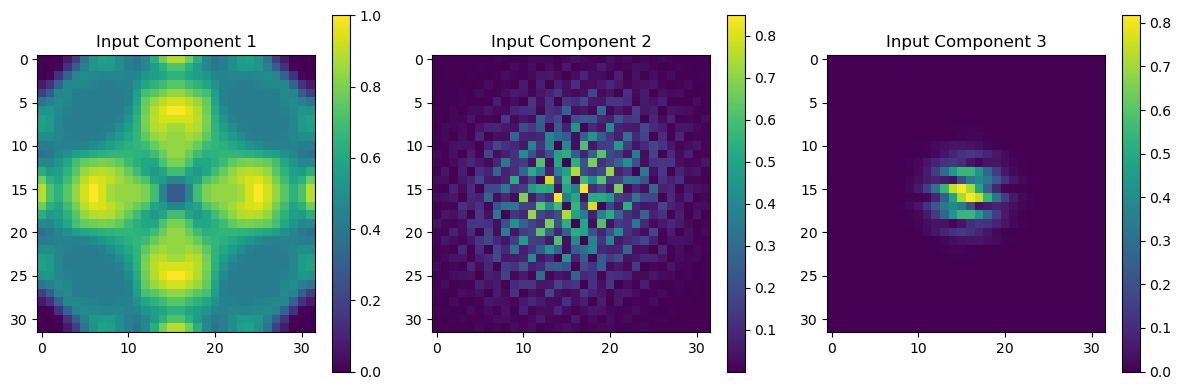

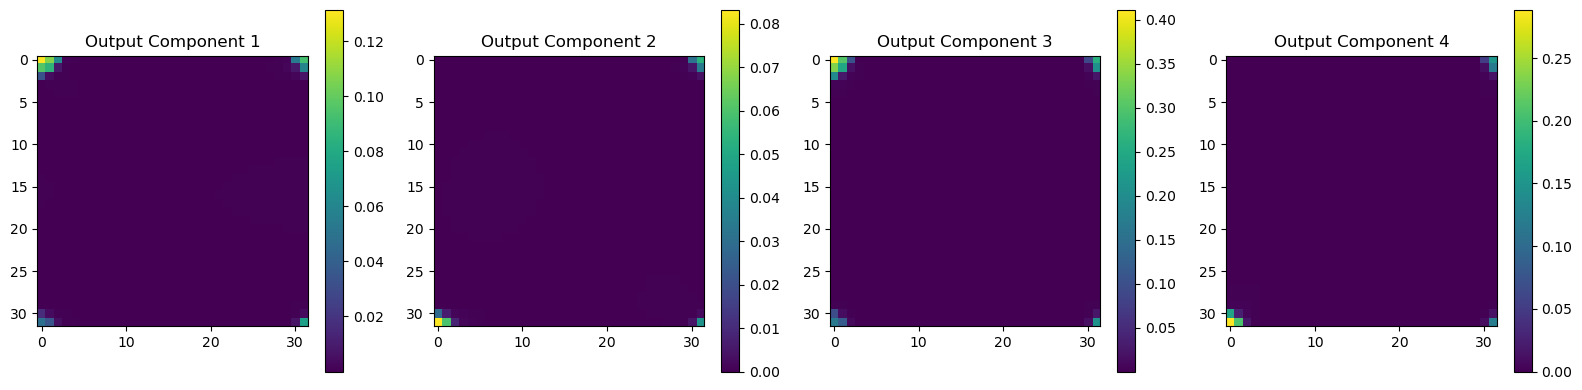


Visualizing sample 141 from loaded reduced dataset:


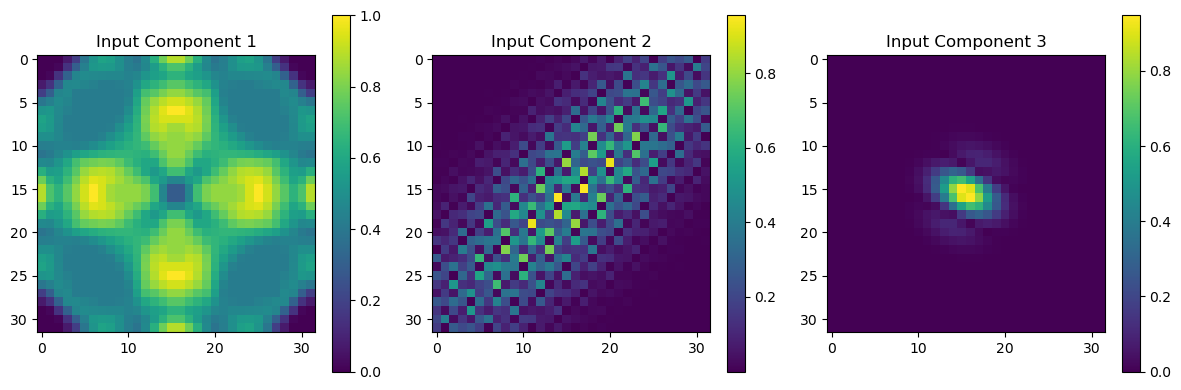

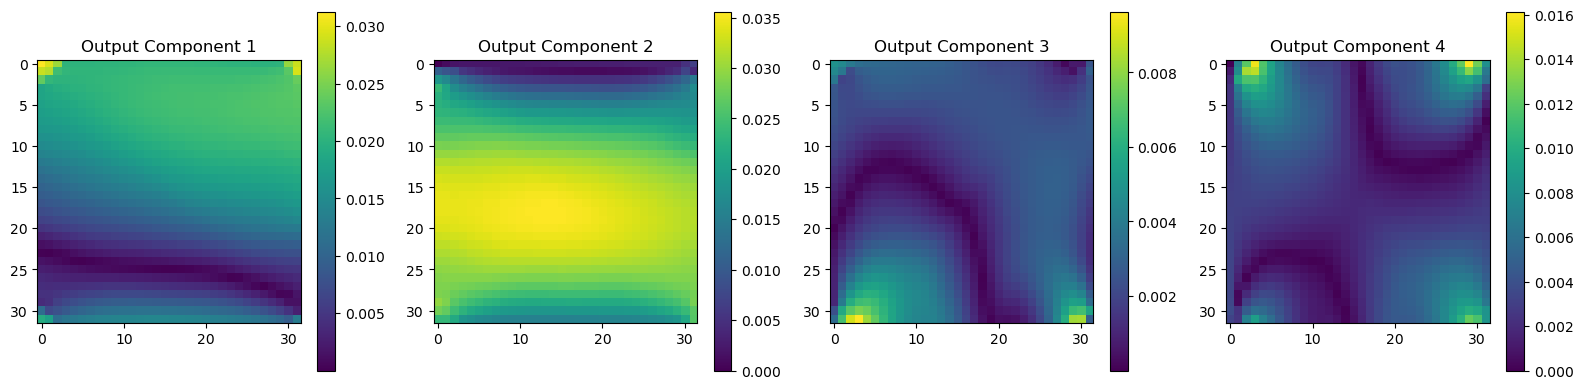


Visualizing sample 120 from loaded reduced dataset:


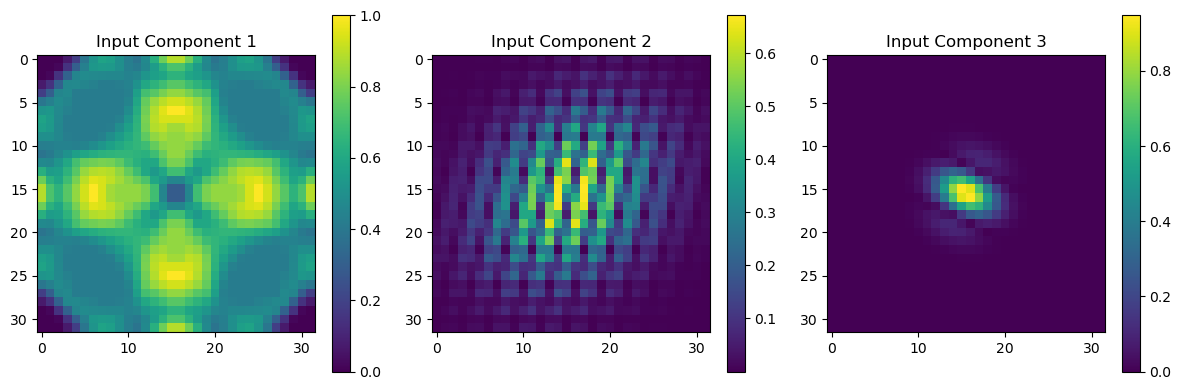

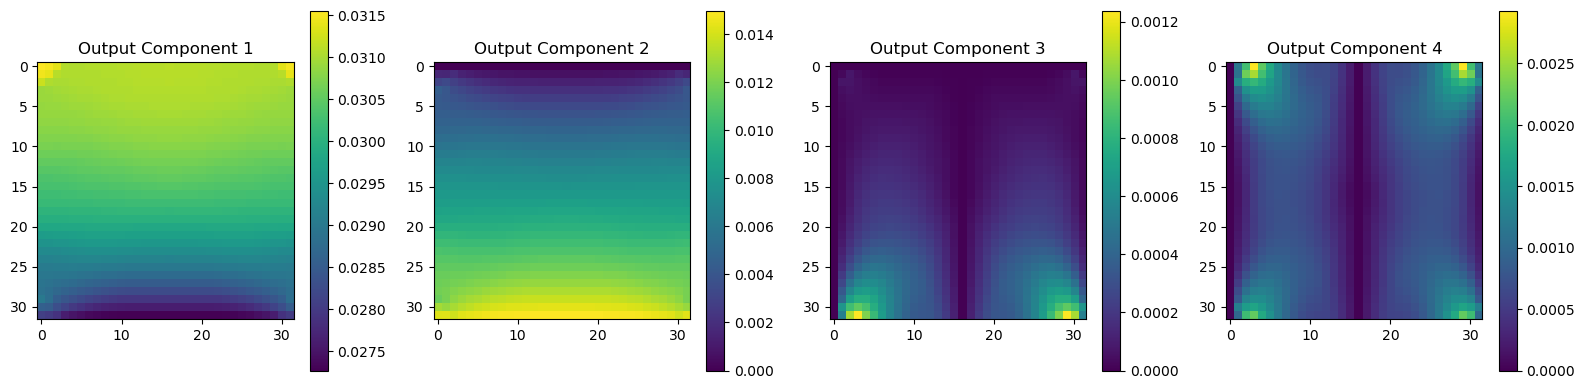


Visualizing sample 139 from loaded reduced dataset:


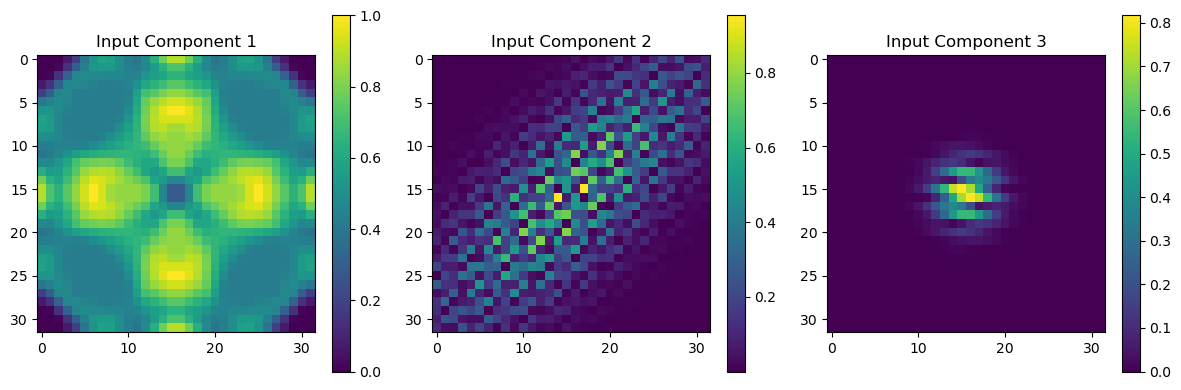

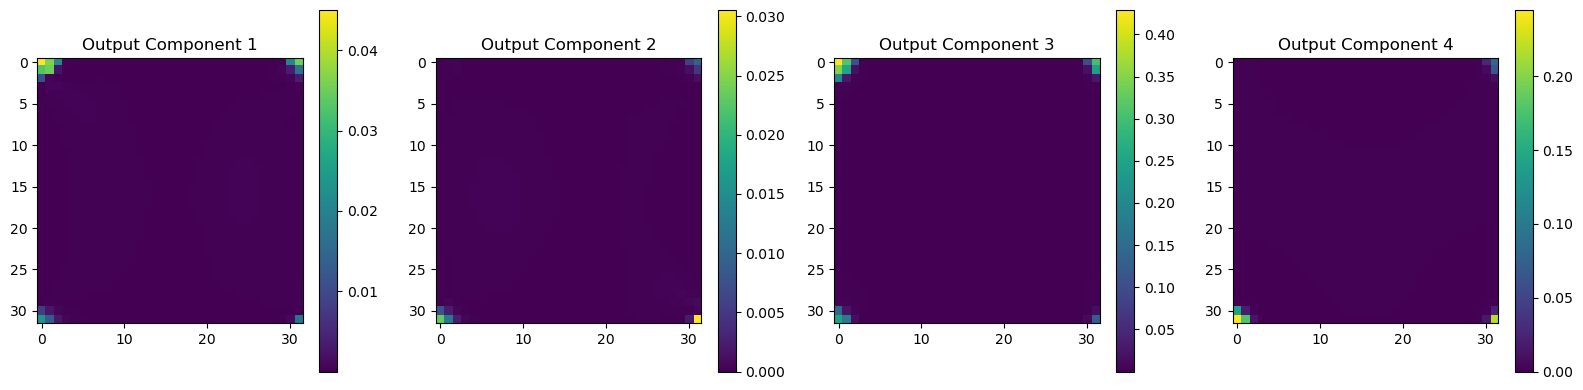


Visualizing random sample 139 from loaded reduced dataset:


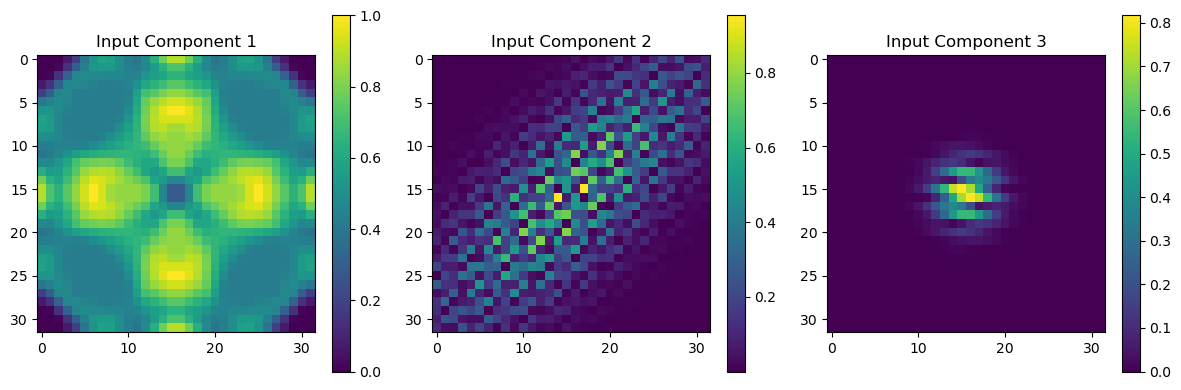

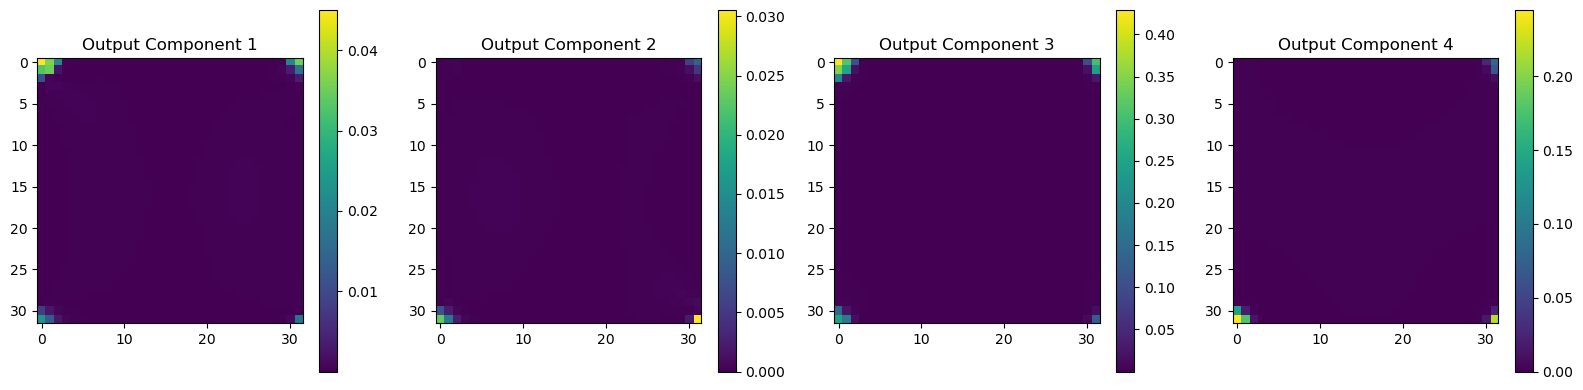

In [15]:
datafolder_name4 = ["data", "set 4"]
data_path4 = os.path.join(*datafolder_name4)
waveform_subset_proportion4 = 0.25
bands_subset_proportion4 = 0.5
precision4 = torch.float32
reduced_dataset4 = load_and_reduce_dataset(data_path4,
                                           waveform_subset_proportion=waveform_subset_proportion4,
                                           bands_subset_proportion=bands_subset_proportion4,
                                           precision=precision4)

reduced_datafolder4_name = ["data", "reduced", "set 4"]
reduced_datapath4 = os.path.join(*reduced_datafolder4_name)
os.makedirs(reduced_datapath4, exist_ok=True)
save_reduced_dataset(reduced_dataset4, reduced_datapath4, suffix='4_ws4_bs2_f32')

In [21]:
#visualize_random_samples(dataset_path=reduced_datapath4, n_samples=6, design_window=243)

# Delete dataset4 related variables to free up memory
del reduced_dataset4

***Process Dataset5***

In [22]:
datafolder_name5 = ["data", "set 5"]
data_path5 = os.path.join(*datafolder_name5)
waveform_subset_proportion5 = 0.25
bands_subset_proportion5 = 0.5
precision5 = torch.float32
reduced_dataset5 = load_and_reduce_dataset(data_path5,
                                           waveform_subset_proportion=waveform_subset_proportion5,
                                           bands_subset_proportion=bands_subset_proportion5,
                                           precision=precision5)

reduced_datafolder5_name = ["data", "reduced", "set 5"]
reduced_datapath5 = os.path.join(*reduced_datafolder5_name)
os.makedirs(reduced_datapath5, exist_ok=True)
save_reduced_dataset(reduced_dataset5, reduced_datapath5, suffix='5_ws4_bs2_f32')

Dataset loaded from data\set 5
Dataset designs shape: (600, 32, 32), dtype: float64
Dataset waveforms shape: (325, 32, 32), dtype: float64
Dataset wavevectors shape: (600, 325, 2), dtype: float16
Dataset eigenvalue_data shape: (600, 325, 6), dtype: float16
Dataset eigenvector_data_x shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset eigenvector_data_y shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset bands_fft shape: (6, 32, 32), dtype: float64
Dataset creation took 59.39 seconds
Input tensor shape: torch.Size([1170000, 3, 32, 32])
Output tensor shape: torch.Size([1170000, 4, 32, 32])
Number of samples in dataset: 1170000

Dataset Information:
Total number of samples: 1170000
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])
Input tensor dtype: torch.float32, Output tensor dtype: torch.float32
reduced_indices shape: (1170000,)
Number of samples in reduced dataset: 145800 (12.46% of original)

Reduced Dataset Informatio

In [23]:
#visualize_random_samples(dataset_path=reduced_datapath5, n_samples=6, design_window=243)

# Delete dataset5 related variables to free up memory
del reduced_dataset5

***Process Dataset6***

In [24]:
datafolder_name6 = ["data", "set 6"]
data_path6 = os.path.join(*datafolder_name6)
waveform_subset_proportion6 = 0.25
bands_subset_proportion6 = 0.5
precision6 = torch.float32
reduced_dataset6 = load_and_reduce_dataset(data_path6,
                                           waveform_subset_proportion=waveform_subset_proportion6,
                                           bands_subset_proportion=bands_subset_proportion6,
                                           precision=precision6)

reduced_datafolder6_name = ["data", "reduced", "set 6"]
reduced_datapath6 = os.path.join(*reduced_datafolder6_name)
os.makedirs(reduced_datapath6, exist_ok=True)
save_reduced_dataset(reduced_dataset6, reduced_datapath6, suffix='6_ws4_bs2_f32')

Dataset loaded from data\set 6
Dataset designs shape: (600, 32, 32), dtype: float64
Dataset waveforms shape: (325, 32, 32), dtype: float64
Dataset wavevectors shape: (600, 325, 2), dtype: float16
Dataset eigenvalue_data shape: (600, 325, 6), dtype: float16
Dataset eigenvector_data_x shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset eigenvector_data_y shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset bands_fft shape: (6, 32, 32), dtype: float64
Dataset creation took 57.48 seconds
Input tensor shape: torch.Size([1170000, 3, 32, 32])
Output tensor shape: torch.Size([1170000, 4, 32, 32])
Number of samples in dataset: 1170000

Dataset Information:
Total number of samples: 1170000
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])
Input tensor dtype: torch.float32, Output tensor dtype: torch.float32
reduced_indices shape: (1170000,)
Number of samples in reduced dataset: 145800 (12.46% of original)

Reduced Dataset Informatio

In [25]:

#visualize_random_samples(dataset_path=reduced_datapath6, n_samples=6, design_window=243)

# Delete dataset6 related variables to free up memory
del reduced_dataset6

***Process Dataset7***

In [26]:
datafolder_name7 = ["data", "set 7"]
data_path7 = os.path.join(*datafolder_name7)
waveform_subset_proportion7 = 0.25
bands_subset_proportion7 = 0.5
precision7 = torch.float32
reduced_dataset7 = load_and_reduce_dataset(data_path7,
                                           waveform_subset_proportion=waveform_subset_proportion7,
                                           bands_subset_proportion=bands_subset_proportion7,
                                           precision=precision7)

reduced_datafolder7_name = ["data", "reduced", "set 7"]
reduced_datapath7 = os.path.join(*reduced_datafolder7_name)
os.makedirs(reduced_datapath7, exist_ok=True)
save_reduced_dataset(reduced_dataset7, reduced_datapath7, suffix='7_ws4_bs2_f32')

Dataset loaded from data\set 7
Dataset designs shape: (600, 32, 32), dtype: float64
Dataset waveforms shape: (325, 32, 32), dtype: float64
Dataset wavevectors shape: (600, 325, 2), dtype: float16
Dataset eigenvalue_data shape: (600, 325, 6), dtype: float16
Dataset eigenvector_data_x shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset eigenvector_data_y shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset bands_fft shape: (6, 32, 32), dtype: float64
Dataset creation took 61.47 seconds
Input tensor shape: torch.Size([1170000, 3, 32, 32])
Output tensor shape: torch.Size([1170000, 4, 32, 32])
Number of samples in dataset: 1170000

Dataset Information:
Total number of samples: 1170000
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])
Input tensor dtype: torch.float32, Output tensor dtype: torch.float32
reduced_indices shape: (1170000,)
Number of samples in reduced dataset: 145800 (12.46% of original)

Reduced Dataset Informatio

In [27]:
#visualize_random_samples(dataset_path=reduced_datapath7, n_samples=6, design_window=243)

# Delete dataset7 related variables to free up memory
del reduced_dataset7

***Process Dataset8***

In [28]:
datafolder_name8 = ["data", "set 8"]
data_path8 = os.path.join(*datafolder_name8)
waveform_subset_proportion8 = 0.25
bands_subset_proportion8 = 0.5
precision8 = torch.float32
reduced_dataset8 = load_and_reduce_dataset(data_path8,
                                           waveform_subset_proportion=waveform_subset_proportion8,
                                           bands_subset_proportion=bands_subset_proportion8,
                                           precision=precision8)

reduced_datafolder8_name = ["data", "reduced", "set 8"]
reduced_datapath8 = os.path.join(*reduced_datafolder8_name)
os.makedirs(reduced_datapath8, exist_ok=True)
save_reduced_dataset(reduced_dataset8, reduced_datapath8, suffix='8_ws4_bs2_f32')

Dataset loaded from data\set 8
Dataset designs shape: (600, 32, 32), dtype: float64
Dataset waveforms shape: (325, 32, 32), dtype: float64
Dataset wavevectors shape: (600, 325, 2), dtype: float16
Dataset eigenvalue_data shape: (600, 325, 6), dtype: float16
Dataset eigenvector_data_x shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset eigenvector_data_y shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset bands_fft shape: (6, 32, 32), dtype: float64
Dataset creation took 66.30 seconds
Input tensor shape: torch.Size([1170000, 3, 32, 32])
Output tensor shape: torch.Size([1170000, 4, 32, 32])
Number of samples in dataset: 1170000

Dataset Information:
Total number of samples: 1170000
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])
Input tensor dtype: torch.float32, Output tensor dtype: torch.float32
reduced_indices shape: (1170000,)
Number of samples in reduced dataset: 145800 (12.46% of original)

Reduced Dataset Informatio

In [29]:
#visualize_random_samples(dataset_path=reduced_datapath8, n_samples=6, design_window=243)

# Delete dataset8 related variables to free up memory
del reduced_dataset8

***Process Dataset9***

In [18]:
datafolder_name9 = ["data", "set 9"]
data_path9 = os.path.join(*datafolder_name9)
waveform_subset_proportion9 = 0.25
bands_subset_proportion9 = 0.5
precision9 = torch.float32
reduced_dataset9 = load_and_reduce_dataset(data_path9, 
                                           waveform_subset_proportion=waveform_subset_proportion9, 
                                           bands_subset_proportion=bands_subset_proportion9, 
                                           precision=precision9)

reduced_datafolder9_name = ["data", "reduced", "set 9"]
reduced_datapath9 = os.path.join(*reduced_datafolder9_name)
os.makedirs(reduced_datapath9, exist_ok=True)
save_reduced_dataset(reduced_dataset9, reduced_datapath9, suffix='9_ws4_bs2_f32')

Dataset loaded from data\set 9
Dataset designs shape: (600, 32, 32), dtype: float16
Dataset waveforms shape: (325, 32, 32), dtype: float16
Dataset wavevectors shape: (600, 325, 2), dtype: float16
Dataset eigenvalue_data shape: (600, 325, 6), dtype: float16
Dataset eigenvector_data_x shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset eigenvector_data_y shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset bands_fft shape: (6, 32, 32), dtype: float16
Dataset creation took 95.77 seconds
Input tensor shape: torch.Size([1170000, 3, 32, 32])
Output tensor shape: torch.Size([1170000, 4, 32, 32])
Number of samples in dataset: 1170000

Dataset Information:
Total number of samples: 1170000
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])
Input tensor dtype: torch.float32, Output tensor dtype: torch.float32
reduced_indices shape: (1170000,)
Number of samples in reduced dataset: 145800 (12.46% of original)

Reduced Dataset Informatio

In [20]:
#visualize_random_samples(dataset_path=reduced_datapath9, n_samples=6, design_window=243)

# Delete dataset9 related variables to free up memory
del reduced_dataset9

***Process Dataset10***

In [21]:
datafolder_name10 = ["data", "set 10"]
data_path10 = os.path.join(*datafolder_name10)
waveform_subset_proportion10 = 0.25
bands_subset_proportion10 = 0.5
precision10 = torch.float32
reduced_dataset10 = load_and_reduce_dataset(data_path10, 
                                           waveform_subset_proportion=waveform_subset_proportion10, 
                                           bands_subset_proportion=bands_subset_proportion10, 
                                           precision=precision10)

reduced_datafolder10_name = ["data", "reduced", "set 10"]
reduced_datapath10 = os.path.join(*reduced_datafolder10_name)
os.makedirs(reduced_datapath10, exist_ok=True)
save_reduced_dataset(reduced_dataset10, reduced_datapath10, suffix='10_ws4_bs2_f32')

Dataset loaded from data\set 10
Dataset designs shape: (600, 32, 32), dtype: float16
Dataset waveforms shape: (325, 32, 32), dtype: float16
Dataset wavevectors shape: (600, 325, 2), dtype: float16
Dataset eigenvalue_data shape: (600, 325, 6), dtype: float16
Dataset eigenvector_data_x shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset eigenvector_data_y shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset bands_fft shape: (6, 32, 32), dtype: float16
Dataset creation took 51.48 seconds
Input tensor shape: torch.Size([1170000, 3, 32, 32])
Output tensor shape: torch.Size([1170000, 4, 32, 32])
Number of samples in dataset: 1170000

Dataset Information:
Total number of samples: 1170000
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])
Input tensor dtype: torch.float32, Output tensor dtype: torch.float32
reduced_indices shape: (1170000,)
Number of samples in reduced dataset: 145800 (12.46% of original)

Reduced Dataset Informati

In [22]:
#visualize_random_samples(dataset_path=reduced_datapath10, n_samples=6, design_window=243)

# Delete dataset10 related variables to free up memory
del reduced_dataset10

***Process Dataset11***

In [23]:
datafolder_name11 = ["data", "set 11"]
data_path11 = os.path.join(*datafolder_name11)
waveform_subset_proportion11 = 0.25
bands_subset_proportion11 = 0.5
precision11 = torch.float32
reduced_dataset11 = load_and_reduce_dataset(data_path11, 
                                           waveform_subset_proportion=waveform_subset_proportion11, 
                                           bands_subset_proportion=bands_subset_proportion11, 
                                           precision=precision11)

reduced_datafolder11_name = ["data", "reduced", "set 11"]
reduced_datapath11 = os.path.join(*reduced_datafolder11_name)
os.makedirs(reduced_datapath11, exist_ok=True)
save_reduced_dataset(reduced_dataset11, reduced_datapath11, suffix='11_ws4_bs2_f32')

Dataset loaded from data\set 11
Dataset designs shape: (600, 32, 32), dtype: float16
Dataset waveforms shape: (325, 32, 32), dtype: float16
Dataset wavevectors shape: (600, 325, 2), dtype: float16
Dataset eigenvalue_data shape: (600, 325, 6), dtype: float16
Dataset eigenvector_data_x shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset eigenvector_data_y shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset bands_fft shape: (6, 32, 32), dtype: float16
Dataset creation took 51.16 seconds
Input tensor shape: torch.Size([1170000, 3, 32, 32])
Output tensor shape: torch.Size([1170000, 4, 32, 32])
Number of samples in dataset: 1170000

Dataset Information:
Total number of samples: 1170000
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])
Input tensor dtype: torch.float32, Output tensor dtype: torch.float32
reduced_indices shape: (1170000,)
Number of samples in reduced dataset: 145800 (12.46% of original)

Reduced Dataset Informati

In [24]:
#visualize_random_samples(dataset_path=reduced_datapath11, n_samples=6, design_window=243)

# Delete dataset11 related variables to free up memory
del reduced_dataset11

***Process Dataset12***

In [25]:
datafolder_name12 = ["data", "set 12"]
data_path12 = os.path.join(*datafolder_name12)
waveform_subset_proportion12 = 0.25
bands_subset_proportion12 = 0.5
precision12 = torch.float32
reduced_dataset12 = load_and_reduce_dataset(data_path12, 
                                           waveform_subset_proportion=waveform_subset_proportion12, 
                                           bands_subset_proportion=bands_subset_proportion12, 
                                           precision=precision12)

reduced_datafolder12_name = ["data", "reduced", "set 12"]
reduced_datapath12 = os.path.join(*reduced_datafolder12_name)
os.makedirs(reduced_datapath12, exist_ok=True)
save_reduced_dataset(reduced_dataset12, reduced_datapath12, suffix='12_ws4_bs2_f32')

Dataset loaded from data\set 12
Dataset designs shape: (600, 32, 32), dtype: float16
Dataset waveforms shape: (325, 32, 32), dtype: float16
Dataset wavevectors shape: (600, 325, 2), dtype: float16
Dataset eigenvalue_data shape: (600, 325, 6), dtype: float16
Dataset eigenvector_data_x shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset eigenvector_data_y shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset bands_fft shape: (6, 32, 32), dtype: float16
Dataset creation took 59.31 seconds
Input tensor shape: torch.Size([1170000, 3, 32, 32])
Output tensor shape: torch.Size([1170000, 4, 32, 32])
Number of samples in dataset: 1170000

Dataset Information:
Total number of samples: 1170000
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])
Input tensor dtype: torch.float32, Output tensor dtype: torch.float32
reduced_indices shape: (1170000,)
Number of samples in reduced dataset: 145800 (12.46% of original)

Reduced Dataset Informati

In [26]:
#visualize_random_samples(dataset_path=reduced_datapath12, n_samples=6, design_window=243)

# Delete dataset12 related variables to free up memory
del reduced_dataset12

***Process Dataset13***

In [9]:
datafolder_name13 = ["data", "set 13"]
data_path13 = os.path.join(*datafolder_name13)
waveform_subset_proportion13 = 0.25
bands_subset_proportion13 = 0.5
precision13 = torch.float32
reduced_dataset13 = load_and_reduce_dataset(data_path13, 
                                           waveform_subset_proportion=waveform_subset_proportion13, 
                                           bands_subset_proportion=bands_subset_proportion13, 
                                           precision=precision13)

reduced_datafolder13_name = ["data", "reduced", "set 13"]
reduced_datapath13 = os.path.join(*reduced_datafolder13_name)
os.makedirs(reduced_datapath13, exist_ok=True)
save_reduced_dataset(reduced_dataset13, reduced_datapath13, suffix='13_ws4_bs2_f32')

Dataset loaded from data\set 13
Dataset designs shape: (600, 32, 32), dtype: float16
Dataset waveforms shape: (325, 32, 32), dtype: float16
Dataset wavevectors shape: (600, 325, 2), dtype: float16
Dataset eigenvalue_data shape: (600, 325, 6), dtype: float16
Dataset eigenvector_data_x shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset eigenvector_data_y shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset bands_fft shape: (6, 32, 32), dtype: float16
Dataset creation took 160.63 seconds
Input tensor shape: torch.Size([1170000, 3, 32, 32])
Output tensor shape: torch.Size([1170000, 4, 32, 32])
Number of samples in dataset: 1170000

Dataset Information:
Total number of samples: 1170000
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])
Input tensor dtype: torch.float32, Output tensor dtype: torch.float32
reduced_indices shape: (1170000,)
Number of samples in reduced dataset: 145800 (12.46% of original)

Reduced Dataset Informat

In [12]:
#visualize_random_samples(dataset_path=reduced_datapath13, n_samples=6, design_window=243)

# Delete dataset13 related variables to free up memory
del reduced_dataset13

***Process Dataset14***

In [10]:
datafolder_name14 = ["data", "set 14"]
data_path14 = os.path.join(*datafolder_name14)
waveform_subset_proportion14 = 0.25
bands_subset_proportion14 = 0.5
precision14 = torch.float32
reduced_dataset14 = load_and_reduce_dataset(data_path14, 
                                           waveform_subset_proportion=waveform_subset_proportion14, 
                                           bands_subset_proportion=bands_subset_proportion14, 
                                           precision=precision14)

reduced_datafolder14_name = ["data", "reduced", "set 14"]
reduced_datapath14 = os.path.join(*reduced_datafolder14_name)
os.makedirs(reduced_datapath14, exist_ok=True)
save_reduced_dataset(reduced_dataset14, reduced_datapath14, suffix='14_ws4_bs2_f32')

Dataset loaded from data\set 14
Dataset designs shape: (600, 32, 32), dtype: float16
Dataset waveforms shape: (325, 32, 32), dtype: float16
Dataset wavevectors shape: (600, 325, 2), dtype: float16
Dataset eigenvalue_data shape: (600, 325, 6), dtype: float16
Dataset eigenvector_data_x shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset eigenvector_data_y shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset bands_fft shape: (6, 32, 32), dtype: float16
Dataset creation took 85.51 seconds
Input tensor shape: torch.Size([1170000, 3, 32, 32])
Output tensor shape: torch.Size([1170000, 4, 32, 32])
Number of samples in dataset: 1170000

Dataset Information:
Total number of samples: 1170000
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])
Input tensor dtype: torch.float32, Output tensor dtype: torch.float32
reduced_indices shape: (1170000,)
Number of samples in reduced dataset: 145800 (12.46% of original)

Reduced Dataset Informati

In [11]:
#visualize_random_samples(dataset_path=reduced_datapath14, n_samples=6, design_window=243)

# Delete dataset14 related variables to free up memory
del reduced_dataset14

***Process Dataset15***

In [13]:
datafolder_name15 = ["data", "set 15"]
data_path15 = os.path.join(*datafolder_name15)
waveform_subset_proportion15 = 0.25
bands_subset_proportion15 = 0.5
precision15 = torch.float32
reduced_dataset15 = load_and_reduce_dataset(data_path15, 
                                           waveform_subset_proportion=waveform_subset_proportion15, 
                                           bands_subset_proportion=bands_subset_proportion15, 
                                           precision=precision15)

reduced_datafolder15_name = ["data", "reduced", "set 15"]
reduced_datapath15 = os.path.join(*reduced_datafolder15_name)
os.makedirs(reduced_datapath15, exist_ok=True)
save_reduced_dataset(reduced_dataset15, reduced_datapath15, suffix='15_ws4_bs2_f32')

Dataset loaded from data\set 15
Dataset designs shape: (600, 32, 32), dtype: float16
Dataset waveforms shape: (325, 32, 32), dtype: float16
Dataset wavevectors shape: (600, 325, 2), dtype: float16
Dataset eigenvalue_data shape: (600, 325, 6), dtype: float16
Dataset eigenvector_data_x shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset eigenvector_data_y shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset bands_fft shape: (6, 32, 32), dtype: float16
Dataset creation took 52.03 seconds
Input tensor shape: torch.Size([1170000, 3, 32, 32])
Output tensor shape: torch.Size([1170000, 4, 32, 32])
Number of samples in dataset: 1170000

Dataset Information:
Total number of samples: 1170000
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])
Input tensor dtype: torch.float32, Output tensor dtype: torch.float32
reduced_indices shape: (1170000,)
Number of samples in reduced dataset: 145800 (12.46% of original)

Reduced Dataset Informati

In [14]:
#visualize_random_samples(dataset_path=reduced_datapath15, n_samples=6, design_window=243)

# Delete dataset15 related variables to free up memory
del reduced_dataset15

***Process Dataset16***

In [15]:
datafolder_name16 = ["data", "set 16"]
data_path16 = os.path.join(*datafolder_name16)
waveform_subset_proportion16 = 0.25
bands_subset_proportion16 = 0.5
precision16 = torch.float32
reduced_dataset16 = load_and_reduce_dataset(data_path16, 
                                           waveform_subset_proportion=waveform_subset_proportion16, 
                                           bands_subset_proportion=bands_subset_proportion16, 
                                           precision=precision16)

reduced_datafolder16_name = ["data", "reduced", "set 16"]
reduced_datapath16 = os.path.join(*reduced_datafolder16_name)
os.makedirs(reduced_datapath16, exist_ok=True)
save_reduced_dataset(reduced_dataset16, reduced_datapath16, suffix='16_ws4_bs2_f32')

Dataset loaded from data\set 16
Dataset designs shape: (600, 32, 32), dtype: float16
Dataset waveforms shape: (325, 32, 32), dtype: float16
Dataset wavevectors shape: (600, 325, 2), dtype: float16
Dataset eigenvalue_data shape: (600, 325, 6), dtype: float16
Dataset eigenvector_data_x shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset eigenvector_data_y shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset bands_fft shape: (6, 32, 32), dtype: float16
Dataset creation took 58.93 seconds
Input tensor shape: torch.Size([1170000, 3, 32, 32])
Output tensor shape: torch.Size([1170000, 4, 32, 32])
Number of samples in dataset: 1170000

Dataset Information:
Total number of samples: 1170000
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])
Input tensor dtype: torch.float32, Output tensor dtype: torch.float32
reduced_indices shape: (1170000,)
Number of samples in reduced dataset: 145800 (12.46% of original)

Reduced Dataset Informati

In [16]:
#visualize_random_samples(dataset_path=reduced_datapath16, n_samples=6, design_window=243)

# Delete dataset16 related variables to free up memory
del reduced_dataset16

***Process Dataset17***

In [13]:
datafolder_name17 = ["data", "set 17"]
data_path17 = os.path.join(*datafolder_name17)
waveform_subset_proportion17 = 0.25
bands_subset_proportion17 = 0.5
precision17 = torch.float32
reduced_dataset17 = load_and_reduce_dataset(data_path17, 
                                           waveform_subset_proportion=waveform_subset_proportion17, 
                                           bands_subset_proportion=bands_subset_proportion17, 
                                           precision=precision17)

reduced_datafolder17_name = ["data", "reduced", "set 17"]
reduced_datapath17 = os.path.join(*reduced_datafolder17_name)
os.makedirs(reduced_datapath17, exist_ok=True)
save_reduced_dataset(reduced_dataset17, reduced_datapath17, suffix='17_ws4_bs2_f32')

Dataset loaded from data\set 17
Dataset designs shape: (600, 32, 32), dtype: float16
Dataset waveforms shape: (325, 32, 32), dtype: float16
Dataset wavevectors shape: (600, 325, 2), dtype: float16
Dataset eigenvalue_data shape: (600, 325, 6), dtype: float16
Dataset eigenvector_data_x shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset eigenvector_data_y shape: (600, 325, 6, 32, 32), dtype: complex64
Dataset bands_fft shape: (6, 32, 32), dtype: float16
Dataset creation took 61.99 seconds
Input tensor shape: torch.Size([1170000, 3, 32, 32])
Output tensor shape: torch.Size([1170000, 4, 32, 32])
Number of samples in dataset: 1170000

Dataset Information:
Total number of samples: 1170000
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])
Input tensor dtype: torch.float32, Output tensor dtype: torch.float32
reduced_indices shape: (1170000,)
Number of samples in reduced dataset: 145800 (12.46% of original)

Reduced Dataset Informati

In [14]:
#visualize_random_samples(dataset_path=reduced_datapath17, n_samples=6, design_window=243)

# Delete dataset17 related variables to free up memory
del reduced_dataset17

Process Dataset test_continuous_1000

In [15]:
datafolder_name_test_cont = ["data", "test_continuous_1000"]
data_path_test_cont = os.path.join(*datafolder_name_test_cont)
waveform_subset_proportion_test_cont = 0.25
bands_subset_proportion_test_cont = 0.5
precision_test_cont = torch.float32
reduced_dataset_test_cont = load_and_reduce_dataset(data_path_test_cont, 
                                           waveform_subset_proportion=waveform_subset_proportion_test_cont, 
                                           bands_subset_proportion=bands_subset_proportion_test_cont, 
                                           precision=precision_test_cont)

reduced_datafolder_test_cont_name = ["data", "reduced", "test_continuous_1000"]
reduced_datapath_test_cont = os.path.join(*reduced_datafolder_test_cont_name)
os.makedirs(reduced_datapath_test_cont, exist_ok=True)
save_reduced_dataset(reduced_dataset_test_cont, reduced_datapath_test_cont, suffix='test_continuous_1000_ws4_bs2_f32')

Dataset loaded from data\test_continuous_1000
Dataset designs shape: (1000, 32, 32), dtype: float16
Dataset waveforms shape: (325, 32, 32), dtype: float16
Dataset wavevectors shape: (1000, 325, 2), dtype: float16
Dataset eigenvalue_data shape: (1000, 325, 6), dtype: float16
Dataset eigenvector_data_x shape: (1000, 325, 6, 32, 32), dtype: complex64
Dataset eigenvector_data_y shape: (1000, 325, 6, 32, 32), dtype: complex64
Dataset bands_fft shape: (6, 32, 32), dtype: float16
Dataset creation took 191.37 seconds
Input tensor shape: torch.Size([1950000, 3, 32, 32])
Output tensor shape: torch.Size([1950000, 4, 32, 32])
Number of samples in dataset: 1950000

Dataset Information:
Total number of samples: 1950000
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])
Input tensor dtype: torch.float32, Output tensor dtype: torch.float32
reduced_indices shape: (1950000,)
Number of samples in reduced dataset: 243000 (12.46% of original)

Reduc

In [16]:
#visualize_random_samples(dataset_path=reduced_datapath_test_cont, n_samples=6, design_window=243)

# Delete dataset_test_cont related variables to free up memory
del reduced_dataset_test_cont

Process Dataset test_binary_1000

In [17]:
datafolder_name_test_bin = ["data", "test_binary_1000"]
data_path_test_bin = os.path.join(*datafolder_name_test_bin)
waveform_subset_proportion_test_bin = 0.25
bands_subset_proportion_test_bin = 0.5
precision_test_bin = torch.float32
reduced_dataset_test_bin = load_and_reduce_dataset(data_path_test_bin, 
                                           waveform_subset_proportion=waveform_subset_proportion_test_bin, 
                                           bands_subset_proportion=bands_subset_proportion_test_bin, 
                                           precision=precision_test_bin)

reduced_datafolder_test_bin_name = ["data", "reduced", "test_binary_1000"]
reduced_datapath_test_bin = os.path.join(*reduced_datafolder_test_bin_name)
os.makedirs(reduced_datapath_test_bin, exist_ok=True)
save_reduced_dataset(reduced_dataset_test_bin, reduced_datapath_test_bin, suffix='test_binary_1000_ws4_bs2_f32')

Dataset loaded from data\test_binary_1000
Dataset designs shape: (1000, 32, 32), dtype: float16
Dataset waveforms shape: (325, 32, 32), dtype: float16
Dataset wavevectors shape: (1000, 325, 2), dtype: float16
Dataset eigenvalue_data shape: (1000, 325, 6), dtype: float16
Dataset eigenvector_data_x shape: (1000, 325, 6, 32, 32), dtype: complex64
Dataset eigenvector_data_y shape: (1000, 325, 6, 32, 32), dtype: complex64
Dataset bands_fft shape: (6, 32, 32), dtype: float16
Dataset creation took 157.49 seconds
Input tensor shape: torch.Size([1950000, 3, 32, 32])
Output tensor shape: torch.Size([1950000, 4, 32, 32])
Number of samples in dataset: 1950000

Dataset Information:
Total number of samples: 1950000
Input tensor size per sample: torch.Size([3, 32, 32])
Output tensor size per sample: torch.Size([4, 32, 32])
Input tensor dtype: torch.float32, Output tensor dtype: torch.float32
reduced_indices shape: (1950000,)
Number of samples in reduced dataset: 243000 (12.46% of original)

Reduced D

In [18]:
#visualize_random_samples(dataset_path=reduced_datapath_test_bin, n_samples=6, design_window=243)

# Delete dataset_test_bin related variables to free up memory
del reduced_dataset_test_bin

***Process Reserved Dataset***

In [4]:
datafolder_name_reserved = ["data", "reserved"]
data_path_reserved = os.path.join(*datafolder_name_reserved)
waveform_subset_proportion_reserved = 0.25
bands_subset_proportion_reserved = 0.5
precision_reserved = torch.float32
reduced_dataset_reserved = load_and_reduce_dataset(data_path_reserved, 
                                           waveform_subset_proportion=waveform_subset_proportion_reserved, 
                                           bands_subset_proportion=bands_subset_proportion_reserved, 
                                           precision=precision_reserved)

reduced_datafolder_reserved = ["data", "reduced", "reserved"]
reduced_datapath_reserved = os.path.join(*reduced_datafolder_reserved)
os.makedirs(reduced_datapath_reserved, exist_ok=True)
save_reduced_dataset(reduced_dataset_reserved, reduced_datapath_reserved, suffix='reserved_ws4_bs2_f32')

NameError: name 'load_and_reduce_dataset' is not defined

In [ ]:
#visualize_random_samples(dataset_path=reduced_datapath_reserved, n_samples=6, design_window=243)

# Delete dataset related variables to free up memory
del reduced_dataset_reserved

In [27]:
import gc
gc.collect()

41119